# Run GNN Models

## Load Data

In [1]:
import numpy as np 
import pandas as pd
import pickle
import os
import networkx as nx
import dgl
import torch

In [2]:
with open("/dsi/sbm/OrrBavly/colon_data/graphs/G_overlap_lcc_246_gnn.pkl", 'rb') as f:
    G_overlap = pickle.load(f)
node_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon/g_overlap_lcc_246_node_meta_gnn.csv")
node_meta = node_meta.loc[:, ~node_meta.columns.str.contains('^Unnamed')]
colon_meta = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/metadata/colon_meta.csv")
colon_meta = colon_meta.loc[:, ~colon_meta.columns.str.contains('^Unnamed')]
valid_samples = colon_meta[colon_meta['N'].isin(['0', '1', '1a', '1b', '2'])]['sample_id'].tolist()


In [3]:
node_meta

,id,sum_fast_weight,avg_fast_weight,sum_slow_weight,avg_slow_weight,V_gene_fast,J_gene_fast,codon_diversity_fast,sample_prevalence_fast,V_gene_slow,...,codon_diversity_slow,sample_prevalence_slow,degree,betweenness,closeness,eigenvector,V_gene_fast_id,V_gene_slow_id,J_gene_fast_id,J_gene_slow_id
0,CASSLLAGTYNEQFF,0.633450,0.633450,0.621356,0.621356,TRBV11-1,TRBJ2-1,38,46,TRBV11-1,...,11,11,1,0.000000,0.111162,1.603855e-05,3,3,6,6
1,CASSSVNQPQHF,1.370906,0.685453,1.590651,0.795326,TRBV6-2,TRBJ1-5,9,15,TRBV12-3,...,5,5,2,0.008163,0.110709,1.389661e-04,25,6,4,4
2,CASSLGDRDTGELFF,9.108662,0.759055,9.535913,0.794659,TRBV12-3,TRBJ2-2,20,29,TRBV11-2,...,6,7,12,0.003569,0.095741,7.238639e-05,6,4,7,7
3,CASSFGGNEKLFF,0.617424,0.617424,0.664843,0.664843,TRBV12-3,TRBJ1-4,20,24,TRBV12-3,...,6,6,1,0.000000,0.089842,4.963792e-07,6,6,3,3
4,CASSLAGAEAFF,6.572671,0.730297,5.968546,0.663172,TRBV11-2,TRBJ1-1,25,29,TRBV5-1,...,5,5,9,0.121807,0.124809,1.275793e-01,4,22,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,CASSYGSNQPQHF,0.673082,0.673082,0.695346,0.695346,TRBV12-3,TRBJ1-5,20,42,TRBV12-3,...,8,7,1,0.000000,0.089123,4.596769e-07,6,6,4,4
242,CASSPSDTQYF,3.974290,0.662382,5.055111,0.842518,TRBV18,TRBJ2-3,39,64,TRBV11-2,...,14,16,6,0.002750,0.106153,3.085686e-04,11,4,8,8
243,CASSPGLDYEQYF,3.207921,0.641584,3.726921,0.745384,TRBV11-2,TRBJ2-7,27,28,TRBV18,...,4,5,5,0.085812,0.108025,2.801964e-05,4,11,11,11
244,CASSLNQGNTEAFF,1.364046,0.682023,1.347463,0.673732,TRBV11-1,TRBJ1-1,10,16,TRBV11-2,...,5,5,2,0.000000,0.073200,7.119434e-09,3,4,0,0


The global correlation graph was built from all 210 repertoires, but supervised training and evaluation used only the 160 samples with clinical phenotype labels.  Unlabeled repertoires contributed to graph topology and node statistics but were not included in the loss function or reported metrics.

In [4]:
# Correct way to get the first edge and its attributes:
u, v, edge_data = next(iter(G_overlap.edges(data=True)))
print(f"Edge ({u}, {v}) attributes: {edge_data}")

Edge (CASSLGRGSGANVLTF, CASSLGGGTYNEQFF) attributes: {'fast_weight': 0.6620007927103068, 'slow_weight': 0.7661279664234611}


In [5]:
relevant_values = ['0', '1', '1a', '1b', '2']
# List of samples to exclude - did not undergo mixcr due to missing lanes.
exclude_samples = ['P2-S8', 'P2-S9', 'P2-S19', 'P8-S18'] # , 'P4-S1'
colon_meta = colon_meta[colon_meta['N'].isin(relevant_values)]
colon_meta = colon_meta[~colon_meta['sample_id'].isin(exclude_samples)].copy()
colon_meta

,filename,sum value,T,N,M,sample_id
0,pool1_S1_TRB_mig_cdr3_clones_all,33296,T3,1b,Mx,P1-S1
2,pool1_S11_TRB_mig_cdr3_clones_all,78560,T2,0,Mx,P1-S11
3,pool1_S12_TRB_mig_cdr3_clones_all,190517,T3,0,Mx,P1-S12
4,pool1_S13_TRB_mig_cdr3_clones_all,72593,T3,0,0,P1-S13
7,pool1_S16_TRB_mig_cdr3_clones_all,270087,T4,1,0,P1-S16
...,...,...,...,...,...,...
209,pool9_S3_TRB_mig_cdr3_clones_all,190092,T1,0,0,P9-S3
210,pool9_S4_TRB_mig_cdr3_clones_all,198511,T2,1,0,P9-S4
211,pool9_S5_TRB_mig_cdr3_clones_all,62094,T3,1,0,P9-S5
213,pool9_S7_TRB_mig_cdr3_clones_all,170894,T2,0,X,P9-S7


In [6]:
ih_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon_hardness_rf_cos_every5_new_mixcr.csv")
ih_df['sample_id'] = ih_df['sample_name'].str.extract(r'^(P\d+-S\d+)')
ih_df

,sample_name,label,false_negative_appearances,false_positive_appearances,total_test_appearances,average_balanced_accuracy,average_f1_score,average_roc_auc_score,average_mcc_score,average_entropy,average_confidence,balanced_accuracy_variance,appearance_rate,sample_id
0,P9-S21_TRB_new_embedded_low,0,0,36,98,0.456122,0.264314,0.450765,-0.088033,0.655969,0.608104,0.007192,0.367347,P9-S21
1,P5-S15_TRB_new_embedded_high,1,69,0,95,0.448684,0.240455,0.464026,-0.105492,0.632274,0.631741,0.007053,0.726316,P5-S15
2,P3-S18_TRB_new_embedded_low,0,0,70,107,0.437150,0.241718,0.432547,-0.126495,0.639296,0.624734,0.006195,0.654206,P3-S18
3,P6-S23_TRB_new_embedded_low,0,0,70,100,0.449000,0.244783,0.448500,-0.103231,0.604720,0.663216,0.006615,0.700000,P6-S23
4,P5-S17_TRB_new_embedded_low,0,0,0,109,0.454128,0.239752,0.473578,-0.095851,0.436683,0.818045,0.006349,0.000000,P5-S17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,P7-S14_TRB_new_embedded_low,0,0,0,109,0.456881,0.240386,0.472913,-0.087983,0.371328,0.858135,0.008911,0.000000,P7-S14
143,P8-S23_TRB_new_embedded_low,0,0,56,98,0.441327,0.246378,0.436939,-0.119757,0.643019,0.623742,0.006354,0.571429,P8-S23
144,P9-S4_TRB_new_embedded_high,1,75,0,92,0.457337,0.255539,0.448913,-0.085257,0.504857,0.750902,0.007590,0.815217,P9-S4
145,P5-S2_TRB_new_embedded_low,0,0,82,91,0.441484,0.243299,0.454368,-0.119221,0.473562,0.784881,0.005906,0.901099,P5-S2


In [7]:
# --- File paths ---
mixcr_dir = "/dsi/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

time_threshold = 750

# --- Load metadata ---
meta_df = pd.read_csv(meta_file)
meta_df = meta_df[["Sample_ID", "extraction_time"]]

# --- Load all mixcr files ---
# Columns to keep from MiXCR files
mixcr_cols = [
    "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
    "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
]

clonotype_dfs = []


for fname in os.listdir(mixcr_dir):
    if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
        sample_prefix = fname.split("_")[0]
        file_path = os.path.join(mixcr_dir, fname)
        if sample_prefix in valid_samples:
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_prefix
            clonotype_dfs.append(df)

# Merge all clonotype data
clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

# Merge with metadata to get extraction time
clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")

# Create 'group' column: fast vs slow
clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")

In [8]:
clonotype_df['Sample_ID'].nunique()

160

In [9]:
def build_sample_graph(sample_id, G_overlap, node_metadata_df, clonotype_df, meta_df, feature_cols, label_col='N'):
    node_list = list(G_overlap.nodes)

    # Step 1: Get sample-specific TCRs (as multiple clonotypes appear in the same sample with different nucleotide seq,
    # we will aggragate its readFraction values across all relevant rows)
    sample_data = (
        clonotype_df[clonotype_df['Sample_ID'] == sample_id]
        .groupby('aaSeqCDR3')[['readFraction']]  # keep only relevant dynamic features
        .sum()  # sum is safe for readFraction; it’s often fractional per chain
    )
    sample_data['present'] = 1  # each TCR now appears once

    # Step 2: Align to node metadata (which is indexed by 'id')
    dynamic_features = (
        sample_data
        .reindex(index=node_metadata_df['id'])
        .fillna(0)
    )

    # 3. Merge static + dynamic node features
    node_features = pd.concat([
        node_metadata_df.set_index('id')[feature_cols],
        dynamic_features
    ], axis=1).reindex(node_list).fillna(0)

    # 4. Convert to tensor
    X = torch.tensor(node_features.values, dtype=torch.float32)

    # 5. Get label
    label_row = meta_df[meta_df['sample_id'] == sample_id]
    if label_row.empty:
        return None  # Skip if no label
    label_value = label_row[label_col].values[0]  # this might be '2', 'sick', etc.
    y_class = 0 if str(label_value) == '0' else 1  # adjust condition as needed
    # Now convert to tensor
    y = torch.tensor([y_class], dtype=torch.long)

    # 6. Build DGL graph
    g_dgl = dgl.from_networkx(G_overlap)
    g_dgl.ndata['feat'] = X
    g_dgl.y = y

    return g_dgl


## GNN

Connect to GPU

In [10]:
import logging
def connect_gpu():

    GPU_DEVICE = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == "cpu":
        logging.warning("CUDA is not available, using CPU for training.")
    else:
        # Print available devices
        num_devices = torch.cuda.device_count()
        logging.info(f"CUDA is available. Number of devices: {num_devices}")
        print(f"CUDA is available. Number of devices: {num_devices}")

        # Try connecting to the specific device
        try:
            torch.cuda.set_device(GPU_DEVICE)  # SET GPU INDEX HERE:
            current_device = torch.cuda.current_device()
            device_name = torch.cuda.get_device_name(current_device)
            logging.info(f"Using GPU device {current_device}: {device_name}")
            print(f"Using GPU device {current_device}: {device_name}")
        except Exception as e:
            logging.error(f"Failed to connect to GPU: {e}")
            device = torch.device("cpu")
    return device

In [8]:
from dgl.data import DGLDataset

class TCRSampleDataset(DGLDataset):
    def __init__(self, G_overlap, node_metadata_df, clonotype_df, meta_df, feature_cols, label_col='N'):
        self.G_overlap = G_overlap
        self.node_metadata_df = node_metadata_df
        self.clonotype_df = clonotype_df
        self.meta_df = meta_df
        self.feature_cols = feature_cols
        self.label_col = label_col
        super().__init__(name='tcr_sample_dataset')

    def process(self):
        self.graphs = []
        self.labels = []
        node_list = list(self.G_overlap.nodes)

        labeled_samples = self.meta_df.dropna(subset=[self.label_col])['sample_id'].unique()
        print(f"Building graphs for {len(labeled_samples)} labeled samples...")

        for sample_id in labeled_samples:
            g = build_sample_graph(
                sample_id,
                self.G_overlap,
                self.node_metadata_df,
                self.clonotype_df,
                self.meta_df,
                self.feature_cols,
                self.label_col
            )
            if g is not None:
                self.graphs.append(g)
                self.labels.append(g.y)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)

def stratified_train_test_split(labels, test_size=0.2, seed=42):
    """
    Split indices into stratified train/test subsets. Focuses on train/test splits, not train/validation split (as split_fold10_manual function does).
    Returns: train_indices, test_indices
    """
    np.random.seed(seed)
    labels = np.array(labels)
    unique_labels = np.unique(labels)

    test_indices = []
    train_indices = []

    for label in unique_labels:
        idx = np.where(labels == label)[0]
        np.random.shuffle(idx)
        n_test = int(np.floor(test_size * len(idx)))
        test_indices.extend(idx[:n_test])
        train_indices.extend(idx[n_test:])

    return np.array(train_indices), np.array(test_indices)

In [8]:
# Define the static node columns to include
feature_cols = [
    'sum_fast_weight', 'avg_fast_weight',
    'sum_slow_weight', 'avg_slow_weight',
    'codon_diversity_fast', 'codon_diversity_slow',
    'sample_prevalence_fast', 'sample_prevalence_slow',
    'V_gene_fast_id', 'J_gene_fast_id',
    'V_gene_slow_id', 'J_gene_slow_id',
    'degree', 'betweenness', 'closeness', 'eigenvector'
]

sample_id = meta_df['Sample_ID'].iloc[0]  # one labeled sample
graph = build_sample_graph(
    sample_id,
    G_overlap,
    node_meta,
    clonotype_df,
    colon_meta,
    feature_cols
)

print(graph.ndata['feat'].shape, graph.y)

torch.Size([246, 18]) tensor([1])


In [11]:
from dgl.dataloading import GraphDataLoader

# Define the static node columns to include
feature_cols = [
    'sum_fast_weight', 'avg_fast_weight',
    'sum_slow_weight', 'avg_slow_weight',
    'codon_diversity_fast', 'codon_diversity_slow',
    'sample_prevalence_fast', 'sample_prevalence_slow',
    'V_gene_fast_id', 'J_gene_fast_id',
    'V_gene_slow_id', 'J_gene_slow_id',
    'degree', 'betweenness', 'closeness', 'eigenvector'
]

# Create dataset
dataset = TCRSampleDataset(
    G_overlap=G_overlap,
    node_metadata_df=node_meta,
    clonotype_df=clonotype_df,
    meta_df=colon_meta,
    feature_cols=feature_cols,
    label_col='N'  # adjust if your label column is named differently
)

Building graphs for 161 labeled samples...


In [12]:
# Optional: split dataset
from sklearn.model_selection import train_test_split

# Step 1: Stratified train+val vs test
labels = [label.item() for _, label in dataset]
train_val_idx, test_idx = stratified_train_test_split(labels, test_size=0.2)

# Step 2: Stratified train vs val (on train_val only)
train_val_labels = [labels[i] for i in train_val_idx]
train_idx, val_idx = stratified_train_test_split(train_val_labels, test_size=0.2)

# Map val_idx to original indices
val_idx = [train_val_idx[i] for i in val_idx]
train_idx = [train_val_idx[i] for i in train_idx]

train_set = [dataset[i] for i in train_idx]
val_set = [dataset[i] for i in val_idx]
test_set = [dataset[i] for i in test_idx]

train_loader = GraphDataLoader(train_set, batch_size=16, shuffle=True, pin_memory=torch.cuda.is_available())
val_loader = GraphDataLoader(val_set, batch_size=16, shuffle=False, pin_memory=torch.cuda.is_available())
test_loader = GraphDataLoader(test_set, batch_size=16, shuffle=False, pin_memory=torch.cuda.is_available())


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class GINClassifier(nn.Module):
    def __init__(self, in_feats, hidden_dim, num_classes, num_layers=2):
        super().__init__()
        self.convs = nn.ModuleList()

        for i in range(num_layers):
            input_dim = in_feats if i == 0 else hidden_dim
            mlp = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(dglnn.GINConv(mlp, learn_eps=True))

        self.pool = dglnn.AvgPooling()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, g, features):
        h = features
        for conv in self.convs:
            h = conv(g, h)
        hg = self.pool(g, h)
        return self.classifier(hg)

from sklearn.metrics import balanced_accuracy_score, f1_score
import time

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for g, label in dataloader:
        g = g.to(device)
        feats = g.ndata['feat'].to(device)
        label = label.to(device)

        optimizer.zero_grad()
        out = model(g, feats)
        loss = criterion(out, label.squeeze(1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds += out.argmax(dim=1).cpu().tolist()
        all_labels += label.cpu().tolist()

    acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for g, label in dataloader:
            g = g.to(device)
            feats = g.ndata['feat'].to(device)
            label = label.to(device)

            out = model(g, feats)
            loss = criterion(out, label.squeeze(1))
            total_loss += loss.item()

            all_preds += out.argmax(dim=1).cpu().tolist()
            all_labels += label.cpu().tolist()

    acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return total_loss / len(dataloader), acc, f1


In [ ]:
device = connect_gpu()
# Infer input/output dimensions from a sample
sample_graph, sample_label = train_set[0]
in_feats = sample_graph.ndata['feat'].shape[1]
num_classes = len(set([label.item() for _, label in dataset]))

# Model
model = GINClassifier(in_feats=in_feats, hidden_dim=64, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()


CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe


In [15]:
import copy

best_val_acc = 0
best_model = None

n_epochs = 50
for epoch in range(n_epochs):
    t0 = time.time()
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model)
    if epoch % 5 == 0:
        print(f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.3f}, F1: {train_f1:.3f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.3f}, F1: {val_f1:.3f} | "
            f"Time: {time.time() - t0:.2f}s")


Epoch 01 | Train Loss: 3.1547, Acc: 0.509, F1: 0.507 | Val Loss: 1.2314, Acc: 0.500, F1: 0.390 | Time: 10.36s
Epoch 06 | Train Loss: 0.6737, Acc: 0.500, F1: 0.390 | Val Loss: 0.8252, Acc: 0.500, F1: 0.390 | Time: 0.07s
Epoch 11 | Train Loss: 0.6583, Acc: 0.500, F1: 0.390 | Val Loss: 0.7278, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 16 | Train Loss: 0.6630, Acc: 0.500, F1: 0.390 | Val Loss: 0.7207, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 21 | Train Loss: 0.6596, Acc: 0.500, F1: 0.390 | Val Loss: 0.7169, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 26 | Train Loss: 0.6546, Acc: 0.500, F1: 0.390 | Val Loss: 0.7161, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 31 | Train Loss: 0.6517, Acc: 0.500, F1: 0.390 | Val Loss: 0.7392, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 36 | Train Loss: 0.6568, Acc: 0.500, F1: 0.390 | Val Loss: 0.7434, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 41 | Train Loss: 0.6556, Acc: 0.500, F1: 0.390 | Val Loss: 0.7459, Acc: 0.500, F1: 0.390 | Time: 0.05s
Epoch 46 | Train L

In [16]:
# Final evaluation on test set
print("\n🔍 Evaluating best model on test set...")
test_loss, test_acc, test_f1 = evaluate(best_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.3f}, F1: {test_f1:.3f}")


🔍 Evaluating best model on test set...
Test Loss: 0.9287, Acc: 0.500, F1: 0.392


## GNN round 2

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import dgl
import pandas as pd
from sklearn.preprocessing import StandardScaler

class SingleGraphSampleDataset(Dataset):
    """
    One item = (graph, dyn_features, presence_mask, label)
    dyn_features  : FloatTensor [num_nodes, D_dyn]
    presence_mask : BoolTensor  [num_nodes]  (True for nodes that appear in sample)
    """
    def __init__(
        self, 
        g_overlap: dgl.DGLGraph,
        node_static_df: pd.DataFrame,
        dynamic_tensor_dict: dict,   # sample_id -> FloatTensor[num_nodes, D_dyn]
        presence_mask_dict: dict,    # sample_id -> BoolTensor[num_nodes]
        label_series: pd.Series,     # index=sample_id, value=label
    ):
        self.g = g_overlap
        # store static features inside the graph once
        self.g.ndata["static"] = torch.tensor(
            node_static_df.values, dtype=torch.float32
        )
        self.samples = list(label_series.index)
        # Convert to string (in case some are int/float), then map '0' -> 0, else 1
        labels = [0 if str(v) == '0' else 1 for v in label_series.values]
        self.y = torch.tensor(labels, dtype=torch.long)
        self.dyn = dynamic_tensor_dict
        self.mask = presence_mask_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sid = self.samples[idx]
        return (
            self.g,                      # shared pointer, no copy
            self.dyn[sid],               # [N,D_dyn]
            self.mask[sid],              # [N]
            self.y[idx]                  # scalar
        )

def collate_fn(batch):
    """Batch size = number of samples in batch (NOT graph batching)."""
    g_list, dyn_list, mask_list, label_list = zip(*batch)
    # All g_list items are the same pointer; keep one
    g = g_list[0]
    dyn = torch.stack(dyn_list, dim=0)      # [B,N,D_dyn]
    mask = torch.stack(mask_list, dim=0)    # [B,N]
    labels = torch.tensor(label_list)
    return g, dyn, mask, labels


In [12]:
import torch.nn as nn
import dgl.nn as dglnn

class MaskedGIN(nn.Module):
    def __init__(
        self,
        static_dim: int,
        dyn_dim: int,
        hidden_dim: int = 128,
        num_layers: int = 3,
        num_classes: int = 2,
        dropout: float = 0.3,
        readout: str = "mean"   # "mean" (default), "att", or "s2s"
    ):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        in_dim = static_dim + dyn_dim

        self.convs = nn.ModuleList()
        mlp = nn.Sequential(nn.Linear(in_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim))
        self.convs.append(dglnn.GINConv(mlp, "sum"))

        for _ in range(num_layers - 1):
            mlp = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim))
            self.convs.append(dglnn.GINConv(mlp, "sum"))

        # Readout layer selection
        if readout == "att":
            self.pool = dglnn.GlobalAttentionPooling(nn.Linear(hidden_dim, 1))
            self.readout_dim = hidden_dim
            self.readout_type = "att"
        elif readout == "s2s":
            self.pool = dglnn.Set2Set(hidden_dim, n_iters=3, n_layers=1)
            self.readout_dim = 2 * hidden_dim
            self.readout_type = "s2s"
        else: # mean
            self.pool = None
            self.readout_dim = hidden_dim
            self.readout_type = "mean"
        self.readout = nn.Linear(self.readout_dim, num_classes)

    def forward(self, g, dyn_feat, presence_mask):
        static = g.ndata["static"]                    # [N, static_dim]
        B, N, D_dyn = dyn_feat.shape                  # Batch size, num_nodes, dyn_dim
        static_expand = static.unsqueeze(0).expand(B, -1, -1)
        h = torch.cat([static_expand, dyn_feat], dim=-1)
        mask_expand = presence_mask.unsqueeze(-1).float()
        h = h * mask_expand
        h = h.view(-1, h.shape[-1])

        batched_g = dgl.batch([g] * B).to(h.device)
        batched_g.ndata["h"] = h

        x = batched_g.ndata["h"]

        for conv in self.convs:
            x = conv(batched_g, x)
            x = torch.relu(x)
            x = self.dropout(x)
        batched_g.ndata["x"] = x

        # Unbatch to get per-graph node features
        x = x.view(B, N, -1)
        mask = presence_mask.unsqueeze(-1)        # [B, N, 1]
        x_masked = x * mask.float()

        if self.readout_type == "att" or self.readout_type == "s2s":
            graph_emb = self.pool(batched_g, batched_g.ndata["x"])
        else: # mean pooling (masked)
            denom = mask.sum(dim=1).clamp(min=1)  # Avoid div by zero
            graph_emb = x_masked.sum(dim=1) / denom

        return self.readout(graph_emb)

In [11]:
# class MaskedSAGE(nn.Module):
#     def __init__(self, static_dim, dyn_dim, hidden=256,
#                  layers=4, n_cls=2, dropout=0.4):
#         super().__init__()
#         self.norm_dyn = nn.LayerNorm(dyn_dim)          # ← ① scale dynamics
#         self.convs = nn.ModuleList()
#         self.convs.append(dglnn.SAGEConv(static_dim + dyn_dim,
#                                          hidden, "mean"))
#         for _ in range(layers - 1):
#             self.convs.append(dglnn.SAGEConv(hidden, hidden, "mean"))
#         self.drop = nn.Dropout(dropout)
#         self.pool = dglnn.GlobalAttentionPooling(nn.Linear(hidden, 1))
#         self.out = nn.Linear(hidden, n_cls)

#     def forward(self, g, dyn, mask):
#         # 1. Expand static features to batch and concatenate with dynamic
#         static = g.ndata["static"].unsqueeze(0).expand(dyn.shape[0], -1, -1)  # [B, N, static_dim]
        
#         # 2. Normalize dynamic features, if norm_dyn exists; otherwise skip
#         if hasattr(self, "norm_dyn") and self.norm_dyn is not None:
#             # If norm_dyn expects (B*N, dyn_dim), flatten, normalize, reshape
#             B, N, D_dyn = dyn.shape
#             dyn_normed = self.norm_dyn(dyn.view(-1, D_dyn)).view(B, N, D_dyn)
#         else:
#             dyn_normed = dyn

#         # 3. Concatenate static + dynamic
#         h = torch.cat([static, dyn_normed], dim=-1)  # [B, N, static_dim + dyn_dim]
#         # 4. Early masking
#         h = h * mask.unsqueeze(-1).float()           # [B, N, F]

#         # 5. Batch-graph and flatten for message passing
#         B, N, F = h.shape
#         bg = dgl.batch([g] * B).to(h.device)
#         h = h.view(-1, F)                            # [B*N, F]

#         # 6. Message passing
#         for conv in self.convs:
#             h = torch.relu(conv(bg, h))
#             h = self.drop(h)

#         # 7. Reshape back to [B, N, H] and late masking
#         h = h.view(B, N, -1) * mask.unsqueeze(-1).float()

#         # 8. Attention or pooling readout
#         graph_emb = self.pool(bg, h.view(-1, h.shape[-1])).view(B, -1)
#         return self.out(graph_emb)


class MaskedSAGE(nn.Module):
    def __init__(self, static_dim, dyn_dim, hidden=256, layers=4, n_cls=2, dropout=0.4):
        super().__init__()
        self.norm_dyn = nn.LayerNorm(dyn_dim)
        self.convs = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        
        # First layer
        self.convs.append(dglnn.SAGEConv(static_dim + dyn_dim, hidden, "mean"))
        
        # Subsequent layers
        for _ in range(layers - 1):
            self.convs.append(dglnn.SAGEConv(hidden, hidden, "mean"))
        
        self.pool = dglnn.GlobalAttentionPooling(nn.Linear(hidden, 1))
        self.out = nn.Linear(hidden, n_cls)

    def forward(self, g, dyn_feat, presence_mask):
        # Follow the same pattern as MaskedGIN
        static = g.ndata["static"]
        B, N, D_dyn = dyn_feat.shape
        static_expand = static.unsqueeze(0).expand(B, -1, -1)
        
        # Normalize dynamic features
        dyn_normed = self.norm_dyn(dyn_feat.view(-1, D_dyn)).view(B, N, D_dyn)
        
        # Concatenate and apply mask
        h = torch.cat([static_expand, dyn_normed], dim=-1)
        mask_expand = presence_mask.unsqueeze(-1).float()
        h = h * mask_expand
        h = h.view(-1, h.shape[-1])

        # Create batched graph
        batched_g = dgl.batch([g] * B).to(h.device)
        
        # SAGE layers
        x = h
        for conv in self.convs:
            x = conv(batched_g, x)
            x = torch.relu(x)
            x = self.dropout(x)
        
        # Set node features on batched graph for pooling
        batched_g.ndata["x"] = x
        
        # Apply late masking
        x = x.view(B, N, -1)
        mask = presence_mask.unsqueeze(-1)
        x_masked = x * mask.float()
        
        # Update batched graph with masked features
        batched_g.ndata["x"] = x_masked.view(-1, x_masked.shape[-1])
        
        # Pool using the batched graph
        graph_emb = self.pool(batched_g, batched_g.ndata["x"])
        
        return self.out(graph_emb)

In [12]:
# masked GAT
import torch.nn.functional as F
import torch.nn as nn
import dgl.nn as dglnn

class MaskedGAT(nn.Module):
    def __init__(self, static_dim, dyn_dim, hidden=128, layers=3, heads=8, dropout=0.3):
        super().__init__()
        self.norm_dyn = nn.LayerNorm(dyn_dim)
        self.convs = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        
        # First layer: input_dim = static_dim + dyn_dim
        self.convs.append(dglnn.GATConv(
            static_dim + dyn_dim, hidden, heads,
            feat_drop=dropout, attn_drop=dropout, allow_zero_in_degree=True
        ))
        
        # Subsequent layers: input_dim = hidden * heads
        for _ in range(layers - 1):
            self.convs.append(dglnn.GATConv(
                hidden * heads, hidden, heads,
                feat_drop=dropout, attn_drop=dropout, allow_zero_in_degree=True
            ))
        
        final_dim = hidden * heads
        self.pool = dglnn.GlobalAttentionPooling(nn.Linear(final_dim, 1))
        self.out = nn.Linear(final_dim, 2)

    def forward(self, g, dyn_feat, presence_mask):
        # Follow the same pattern as MaskedGIN
        static = g.ndata["static"]
        B, N, D_dyn = dyn_feat.shape
        static_expand = static.unsqueeze(0).expand(B, -1, -1)
        
        # Normalize dynamic features
        dyn_normed = self.norm_dyn(dyn_feat.view(-1, D_dyn)).view(B, N, D_dyn)
        
        # Concatenate and apply mask
        h = torch.cat([static_expand, dyn_normed], dim=-1)
        mask_expand = presence_mask.unsqueeze(-1).float()
        h = h * mask_expand
        h = h.view(-1, h.shape[-1])

        # Create batched graph
        batched_g = dgl.batch([g] * B).to(h.device)
        
        # GAT layers
        x = h
        for conv in self.convs:
            x = conv(batched_g, x)      # Output: [num_nodes, heads, hidden]
            x = x.flatten(1)            # Flatten heads: [num_nodes, heads*hidden]
            x = F.relu(x)
            x = self.dropout(x)
        
        # Set node features on batched graph for pooling
        batched_g.ndata["x"] = x
        
        # Apply late masking
        x = x.view(B, N, -1)
        mask = presence_mask.unsqueeze(-1)
        x_masked = x * mask.float()
        
        # Update batched graph with masked features
        batched_g.ndata["x"] = x_masked.view(-1, x_masked.shape[-1])
        
        # Pool using the batched graph
        graph_emb = self.pool(batched_g, batched_g.ndata["x"])
        
        return self.out(graph_emb)

Load the data:

In [12]:
# ## NOTE! this code is considered bad pracitve, as it scales the rf values based on ALL data, not just train indices. please reffer to 
# ## build_orig_dyn_feat_dict for fixed code.

# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # 1. Gather all values (for TCRs present) for fitting the scaler
# all_rf = clonotype_df['readFraction'].values
# all_rf_log = np.log1p(all_rf).reshape(-1, 1)   # shape [total_rows, 1]
# rf_scaler = StandardScaler().fit(all_rf_log)

# node_list = list(G_overlap.nodes)  # Fixed node order!
# node_idx = {tcr: i for i, tcr in enumerate(node_list)}
# num_nodes = len(node_list)
# sample_ids = clonotype_df['Sample_ID'].unique()
# # If only one dynamic feature: readFraction
# D_dyn = 1

# dyn_feat_dict = {}
# presence_mask_dict = {}

# for sid in sample_ids:
#     df_sample = clonotype_df[clonotype_df['Sample_ID'] == sid]
#     # Aggregate (sum) by aaSeqCDR3
#     agg = df_sample.groupby('aaSeqCDR3').agg({
#         'readFraction': 'sum',  # or 'mean', but 'sum' usually matches MiXCR downstream
#         'readCount': 'sum'      # or other aggregations for other features
#         # add any dynamic columns here
#     }).reset_index()
#     # Create dicts
#     tcr_to_rf = dict(zip(agg['aaSeqCDR3'], agg['readFraction']))
#     tcr_to_rc = dict(zip(agg['aaSeqCDR3'], agg['readCount']))
#     # Dynamic features: fill [num_nodes, D_dyn]
#     dyn_feats = np.zeros((num_nodes, D_dyn), dtype=np.float32)
#     presence = np.zeros(num_nodes, dtype=bool)
#     for tcr, idx in node_idx.items():
#         if tcr in tcr_to_rf:
#             # Log-transform and scale readFraction
#             rf_log = np.log1p(tcr_to_rf[tcr])
#             rf_scaled = rf_scaler.transform([[rf_log]])[0, 0]
#             dyn_feats[idx, 0] = rf_scaled
#             if D_dyn > 1:
#                 dyn_feats[idx, 1] = tcr_to_rc[tcr]  # Optional: apply log+scaling here too!
#             presence[idx] = True
#     # Convert to torch.Tensor
#     dyn_feat_dict[sid] = torch.tensor(dyn_feats, dtype=torch.float32)
#     presence_mask_dict[sid] = torch.tensor(presence, dtype=torch.bool)

# #assert set(sample_ids) == set(dyn_feat_dict.keys()) == set(presence_mask_dict.keys())


In [13]:
from sklearn.preprocessing import StandardScaler

def scale_dyn_dict(train_sample_ids, all_sample_ids, orig_dyn_feat_dict):
    """Fit scaler on train samples, apply to all (returns new dict)."""
    # Stack all train features: shape [N_train_samples * num_nodes, D_dyn]
    train_dyn = torch.cat([orig_dyn_feat_dict[s] for s in train_sample_ids], dim=0).numpy()
    scaler = StandardScaler().fit(train_dyn)

    new_dyn = {}
    for s in all_sample_ids:
        arr = orig_dyn_feat_dict[s].numpy()
        arr_scaled = scaler.transform(arr)
        new_dyn[s] = torch.from_numpy(arr_scaled).float()
    return new_dyn


def build_orig_dyn_feat_dict(clonotype_df, node_idx, sample_ids, if_presence=False):
    """
    Builds the [log(readFraction)] or [log_rf, presence] dynamic feature tensor for each sample.
    Also creates a presence mask dict: torch.bool [num_nodes].
    Returns: orig_dyn_feat_dict, presence_mask_dict
    """
    orig_dyn_feat_dict = {}
    presence_mask_dict = {}
    num_nodes = len(node_idx)
    for sid in sample_ids:
        df_sample = clonotype_df[clonotype_df['Sample_ID'] == sid]
        agg = df_sample.groupby('aaSeqCDR3').agg({'readFraction': 'sum'}).reset_index()
        tcr_to_rf = dict(zip(agg['aaSeqCDR3'], agg['readFraction']))

        log_rf   = np.zeros(num_nodes, dtype=np.float32)
        presence = np.zeros(num_nodes, dtype=np.float32)
        for tcr, idx in node_idx.items():
            rf = tcr_to_rf.get(tcr, 0.0)
            log_rf[idx] = np.log1p(rf)
            presence[idx] = 1.0 if rf > 0 else 0.0

        if if_presence:
            # Stack into [num_nodes, 2]: [log_rf, presence]
            dyn = np.stack([log_rf, presence], axis=1)
        else:
            # Only [log_rf], shape [num_nodes, 1]
            dyn = log_rf[:, None]

        orig_dyn_feat_dict[sid] = torch.from_numpy(dyn).float()
        # Presence mask: torch.bool, True where presence > 0
        presence_mask_dict[sid] = torch.from_numpy(presence > 0).bool()

    return orig_dyn_feat_dict, presence_mask_dict


In [14]:
from sklearn.preprocessing import StandardScaler

device = connect_gpu()

# Drop string columns (keep *_id)
string_cols = [
    "id", "V_gene_fast", "J_gene_fast", "V_gene_slow", "J_gene_slow"
]
node_meta_numeric = node_meta.drop(columns=string_cols)

# List of columns to normalize
cols_to_normalize = [
    'sum_fast_weight', 'avg_fast_weight', 'sum_slow_weight',
    'avg_slow_weight', 'codon_diversity_fast', 'sample_prevalence_fast',
    'codon_diversity_slow', 'sample_prevalence_slow',
    'degree', 'betweenness', 'closeness', 'eigenvector'
]

scaler = StandardScaler()
node_meta_numeric[cols_to_normalize] = scaler.fit_transform(node_meta_numeric[cols_to_normalize])

# Check all remaining columns are numeric
assert all([np.issubdtype(dtype, np.number) for dtype in node_meta_numeric.dtypes])

# If G_overlap is a NetworkX graph:
G_overlap_dgl = dgl.from_networkx(G_overlap)

node_list = list(G_overlap.nodes)
node_idx = {tcr: i for i, tcr in enumerate(node_list)}



CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe


In [15]:
from sklearn.metrics import balanced_accuracy_score, f1_score
import torch.optim as optim

def train_one_epoch(model, loader, device, criterion, optimizer):
    model.train()
    total_loss = 0
    for g, dyn, mask, y in loader:
        dyn, mask, y = dyn.to(device), mask.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(g.to(device), dyn, mask) # calls forward function
        loss = criterion(logits, y)
        loss.backward()
        # # Gradient clipping!
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item() * y.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    all_pred, all_true = [], []
    for g,dyn,mask,y in loader:
        probs = model(g.to(device), dyn.to(device), mask.to(device))
        preds = probs.argmax(dim=1).cpu()
        all_pred.extend(preds)
        all_true.extend(y)
    bal_acc = balanced_accuracy_score(all_true, all_pred)
    f1 = f1_score(all_true, all_pred, average="binary")
    return bal_acc, f1

### Load Samples

In [16]:
from sklearn.model_selection import train_test_split

all_samples = colon_meta['sample_id'].tolist()
# colon_meta = colon_meta.set_index('sample_id')
labels = [0 if str(v) == "0" else 1 for v in colon_meta.set_index('sample_id').loc[all_samples, 'N']]
# r_state=2

trainval_ids, test_ids, trainval_labels, test_labels = train_test_split(
    all_samples, labels, test_size=0.15, stratify=labels)

train_ids, val_ids, train_labels, val_labels = train_test_split(
    trainval_ids, trainval_labels, test_size=0.1, stratify=trainval_labels)

In [17]:
orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict(
    clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)
dyn_feat_dict_scaled = scale_dyn_dict(train_ids, all_samples, orig_dyn_feat_dict)


In [18]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader

dataset = SingleGraphSampleDataset(
    G_overlap_dgl,
    node_meta_numeric,
    dyn_feat_dict_scaled,
    presence_mask_dict,
    colon_meta.set_index("sample_id")["N"]  # labels
)

def sample_id_subset(dataset, subset_ids):
    # Get indices of these IDs in dataset.samples
    id_to_idx = {sid: i for i, sid in enumerate(dataset.samples)}
    subset_indices = [id_to_idx[sid] for sid in subset_ids]
    return Subset(dataset, subset_indices)

train_set = sample_id_subset(dataset, train_ids)
val_set = sample_id_subset(dataset, val_ids)
test_set  = sample_id_subset(dataset, test_ids)

BATCH_SIZE = 16   # or whatever fits in GPU memory

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Optional: IH curriculum learning

In [19]:
id2ih = dict(zip(ih_df['sample_id'], ih_df['appearance_rate']))  # {sample_id: IH score}

full_ih = np.ones(len(dataset.samples), dtype=np.float32)
id2idx = {sid: i for i, sid in enumerate(dataset.samples)}

for sid, ih in id2ih.items():
    if sid in id2idx:
        full_ih[id2idx[sid]] = ih

In [20]:
import torch
from torch.utils.data import DataLoader, Sampler

class IHCurriculumSampler(Sampler):
    def __init__(self, indices, ih_vec, labels, epochs, start_ratio=0.5, end_ratio=1.0):
        self.idx = np.array(indices)
        self.ih = ih_vec[self.idx]
        self.labels = np.array(labels)
        self.T = epochs
        self.r0, self.r1 = start_ratio, end_ratio
        self.set_epoch(0)
    # def set_epoch(self, epoch):
    #     frac = self.r0 + (self.r1 - self.r0) * min(epoch, self.T-1) / (self.T-1)
    #     k = int(len(self.idx) * frac)
    #     # Easiest first (lowest IH)
    #     self.curr_subset = self.idx[np.argsort(self.ih)[:k]]
    def set_epoch(self, epoch):
        """
        New method ensured stratified samples from both classes.
        """
        frac = self.r0 + (self.r1 - self.r0) * min(epoch, self.T-1) / (self.T-1)
        # Split idx by class
        class0 = [i for i in self.idx if self.labels[i] == 0]
        class1 = [i for i in self.idx if self.labels[i] == 1]

        k0 = max(1, int(len(class0) * frac))
        k1 = max(1, int(len(class1) * frac))

        # Get indices of easiest within each class (lowest IH)
        sorted0 = sorted(class0, key=lambda i: self.ih[np.where(self.idx == i)[0][0]])
        sorted1 = sorted(class1, key=lambda i: self.ih[np.where(self.idx == i)[0][0]])
        selected0 = sorted0[:k0]
        selected1 = sorted1[:k1]

        self.curr_subset = np.array(selected0 + selected1)
    def __iter__(self):
        perm = np.random.permutation(self.curr_subset)
        return iter(perm.tolist())
    def __len__(self):
        return len(self.curr_subset)


### GIN

TODO: Remmember to always calculate new dyn_feat_dict_scaled variable for each new train-test split, as dyn_feat_dict_scaled uses the current train_ids to scale its data!

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        alpha: tensor of shape (num_classes,) or float or None for no class balancing
        gamma: focusing parameter (typically 2)
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # pt = softmax probability of correct class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [21]:
import copy

dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]

model = MaskedGIN(
    static_dim=node_meta_numeric.shape[1],
    dyn_dim=dyn_dim,          # len(dynamic feature columns we've added [if only readFraction, than 1])
    hidden_dim=256,
    num_layers=4,
    num_classes=2,
    dropout=0.4,
    readout='att'
).to(device)

# loss function
class_counts = np.bincount(labels)   # [101,  58]

# alpha = 1.0 / torch.tensor(class_counts, dtype=torch.float32)  # or use sklearn.utils.class_weight
# alpha = alpha / alpha.sum()  # normalize if desired
# alpha = alpha.to(device)
# criterion = FocalLoss(alpha=alpha, gamma=3, reduction='sum')
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
criterion  = nn.CrossEntropyLoss(weight=weights.to(device))
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001317068181, weight_decay=0.0001561646)

best_ba = 0; best_f1 = 0
patience = 50
epochs_since_best = 0
max_epochs = 200
best_state = None

for epoch in range(max_epochs):
    train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
    ba, f1 = evaluate(model, val_loader, device)
    if epoch % 3 == 0:
        print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | "
            f"Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
    if ba > best_ba:
        best_ba = ba; best_f1 = f1
        epochs_since_best = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        epochs_since_best += 1
    if epochs_since_best >= patience:
        break

# for epoch in range(1, 251):
#     train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
#     val_balacc, val_f1 = evaluate(model, val_loader, device)
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | "
#             f"Val bal-acc {val_balacc:.3f} | Val F1 {val_f1:.3f}")


test_balacc, test_f1 = evaluate(model, test_loader, device)
print(f"Test baln-acc:{test_balacc}, test F1:{test_f1}")

Epoch 00 | Loss 1.0163 | Val bal-acc 0.500 | Val F1 0.526
Epoch 03 | Loss 0.7310 | Val bal-acc 0.522 | Val F1 0.462
Epoch 06 | Loss 0.6923 | Val bal-acc 0.500 | Val F1 0.000
Epoch 09 | Loss 0.6883 | Val bal-acc 0.500 | Val F1 0.000
Epoch 12 | Loss 0.6846 | Val bal-acc 0.444 | Val F1 0.000
Epoch 15 | Loss 0.6790 | Val bal-acc 0.433 | Val F1 0.222
Epoch 18 | Loss 0.6908 | Val bal-acc 0.444 | Val F1 0.000
Epoch 21 | Loss 0.6973 | Val bal-acc 0.600 | Val F1 0.333
Epoch 24 | Loss 0.6834 | Val bal-acc 0.444 | Val F1 0.000
Epoch 27 | Loss 0.6795 | Val bal-acc 0.356 | Val F1 0.375
Epoch 30 | Loss 0.6719 | Val bal-acc 0.589 | Val F1 0.444
Epoch 33 | Loss 0.6688 | Val bal-acc 0.422 | Val F1 0.333
Epoch 36 | Loss 0.6704 | Val bal-acc 0.422 | Val F1 0.333
Epoch 39 | Loss 0.6405 | Val bal-acc 0.422 | Val F1 0.333
Epoch 42 | Loss 0.6337 | Val bal-acc 0.422 | Val F1 0.333
Epoch 45 | Loss 0.6111 | Val bal-acc 0.478 | Val F1 0.364
Epoch 48 | Loss 0.6994 | Val bal-acc 0.578 | Val F1 0.500
Epoch 51 | Los

In [22]:
test_balacc, test_f1 = evaluate(model, test_loader, device)
print(f"Test baln-acc:{test_balacc}, test F1:{test_f1}")

Test baln-acc:0.47777777777777775, test F1:0.5161290322580645


Lets try curriculum learning:

### TAG

Notice that if you are chaning the samples arrangment between train/val/test, you should create a new dyn_feat_dict_scaled variable.

In [22]:
import copy

seed = 2
max_epochs = 150

BATCH_SIZE = 16
train_indices = [dataset.samples.index(sid) for sid in train_ids]
sampler = IHCurriculumSampler(train_indices, full_ih, labels=labels, epochs=max_epochs, start_ratio=0.5, end_ratio=1.0) # labels if loaded above, under "Load Samples" Section
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=collate_fn) # Sampler only yields the indices of your training 
                                                                                                  # samples, uses the full Dataset (for matching indices)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("Train label counts:", np.bincount(train_labels))
print("Val label counts:", np.bincount(val_labels))

# print("train_set length:", len(train_set))
# print("train_indices:", train_indices[:10], "...", train_indices[-10:])
# # Make sure all indices are valid for train_set!
# assert all(idx < len(train_set) for idx in train_indices)

dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]

model = MaskedGIN(
    static_dim=node_meta_numeric.shape[1],
    dyn_dim=dyn_dim,          # len(dynamic feature columns we've added [if only readFraction, than 1])
    hidden_dim=256,
    num_layers=4,
    num_classes=2,
    dropout=0.4,
    readout='att'
).to(device)

# loss function
class_counts = np.bincount(labels)   # [101,  58]

# alpha = 1.0 / torch.tensor(class_counts, dtype=torch.float32)  # or use sklearn.utils.class_weight
# alpha = alpha / alpha.sum()  # normalize if desired
# alpha = alpha.to(device)
# criterion = FocalLoss(alpha=alpha, gamma=3, reduction='sum')

# weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
# criterion  = nn.CrossEntropyLoss(weight=weights.to(device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0)

best_ba = 0; best_f1 = 0
patience = 50
epochs_since_best = 0
# max_epochs = 120
best_state = None

for epoch in range(max_epochs):
    sampler.set_epoch(epoch)  # Move curriculum "window"
    train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
    ba, f1 = evaluate(model, val_loader, device)
    if epoch % 2 == 0:
        # curr_labels = [labels[i] for i in sampler.curr_subset]
        # print(f"Epoch {epoch}: class balance: {np.bincount(curr_labels)}")
        print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | "
            f"Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
    if ba > best_ba:
        best_ba = ba; best_f1 = f1
        epochs_since_best = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        epochs_since_best += 1
    if epochs_since_best >= patience:
        break

test_balacc, test_f1 = evaluate(model, test_loader, device)
print(f"Test baln-acc:{test_balacc}, test F1:{test_f1}")

Train label counts: [78 44]
Val label counts: [9 5]
Epoch 00 | Loss 167.9151 | Val bal-acc 0.500 | Val F1 0.526
Epoch 02 | Loss 0.2498 | Val bal-acc 0.500 | Val F1 0.000
Epoch 04 | Loss 0.2527 | Val bal-acc 0.500 | Val F1 0.000
Epoch 06 | Loss 0.2570 | Val bal-acc 0.500 | Val F1 0.000
Epoch 08 | Loss 0.2629 | Val bal-acc 0.500 | Val F1 0.000
Epoch 10 | Loss 0.2641 | Val bal-acc 0.500 | Val F1 0.000
Epoch 12 | Loss 0.2708 | Val bal-acc 0.500 | Val F1 0.000
Epoch 14 | Loss 0.2792 | Val bal-acc 0.500 | Val F1 0.000
Epoch 16 | Loss 0.2779 | Val bal-acc 0.500 | Val F1 0.000
Epoch 18 | Loss 0.2673 | Val bal-acc 0.500 | Val F1 0.000
Epoch 20 | Loss 0.2793 | Val bal-acc 0.500 | Val F1 0.000
Epoch 22 | Loss 0.2812 | Val bal-acc 0.500 | Val F1 0.000
Epoch 24 | Loss 0.2827 | Val bal-acc 0.500 | Val F1 0.000
Epoch 26 | Loss 0.2881 | Val bal-acc 0.500 | Val F1 0.000
Epoch 28 | Loss 0.2935 | Val bal-acc 0.500 | Val F1 0.000
Epoch 30 | Loss 0.2940 | Val bal-acc 0.500 | Val F1 0.000
Epoch 32 | Loss 0.

Try overfit on a small dataset.

In [27]:
import numpy as np

# Suppose dataset.samples and labels are aligned
labels_arr = np.array(labels)
class0_idx = np.where(labels_arr == 0)[0]
class1_idx = np.where(labels_arr == 1)[0]

n = 5  # Number per class
tiny_indices = np.concatenate([class0_idx[:n], class1_idx[:n]])
np.random.shuffle(tiny_indices)  # Optional

# If using curriculum sampler, just use these indices
sampler = torch.utils.data.SubsetRandomSampler(tiny_indices)
tiny_loader = DataLoader(dataset, batch_size=4, sampler=sampler, collate_fn=collate_fn)

# Get sample IDs from indices
tiny_sample_ids = [dataset.samples[i] for i in tiny_indices]

orig_dyn_feat_dict_small, presence_mask_dict_small = build_orig_dyn_feat_dict(
    clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)
dyn_feat_dict_small = scale_dyn_dict(tiny_sample_ids, all_samples, orig_dyn_feat_dict)

dataset_small = SingleGraphSampleDataset(
    G_overlap_dgl,
    node_meta_numeric,
    dyn_feat_dict_small,
    presence_mask_dict_small,
    colon_meta.set_index("sample_id")["N"]  # labels
)

from sklearn.metrics import f1_score, balanced_accuracy_score

dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]

model = MaskedGIN(
    static_dim=node_meta_numeric.shape[1],
    dyn_dim=dyn_dim,          # len(dynamic feature columns we've added [if only readFraction, than 1])
    hidden_dim=256,
    num_layers=4,
    num_classes=2,
    dropout=0.2,
    readout='att'
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0)

all_true, all_pred = [], []
for epoch in range(100):
    model.train()
    for g, dyn, mask, y in tiny_loader:
        optimizer.zero_grad()
        logits = model(g.to(device), dyn.to(device), mask.to(device))
        loss = criterion(logits, y.to(device))
        loss.backward()
        optimizer.step()
    # Evaluate
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for g, dyn, mask, y in tiny_loader:
            logits = model(g.to(device), dyn.to(device), mask.to(device))
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred)
            targets.extend(y.cpu().numpy())
    ba = balanced_accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)
    if epoch % 5 == 0 or ba == 1.0:
        print(f"Epoch {epoch:02d} | Loss {loss.item():.4f} | Bal-Acc {ba:.3f} | F1 {f1:.3f}")
    if ba == 1.0 and f1 == 1.0:
        break


Epoch 00 | Loss 516.0769 | Bal-Acc 0.500 | F1 0.000
Epoch 05 | Loss 0.7503 | Bal-Acc 0.600 | F1 0.333
Epoch 10 | Loss 1.0918 | Bal-Acc 0.500 | F1 0.667
Epoch 15 | Loss 0.6832 | Bal-Acc 0.600 | F1 0.667
Epoch 20 | Loss 0.7038 | Bal-Acc 0.700 | F1 0.727
Epoch 25 | Loss 0.4080 | Bal-Acc 0.600 | F1 0.333
Epoch 30 | Loss 0.5447 | Bal-Acc 0.600 | F1 0.667
Epoch 35 | Loss 0.4579 | Bal-Acc 0.600 | F1 0.333
Epoch 40 | Loss 0.7694 | Bal-Acc 0.800 | F1 0.750
Epoch 45 | Loss 0.7439 | Bal-Acc 0.700 | F1 0.571
Epoch 50 | Loss 0.7100 | Bal-Acc 0.600 | F1 0.667
Epoch 55 | Loss 0.6261 | Bal-Acc 0.700 | F1 0.571
Epoch 60 | Loss 0.5966 | Bal-Acc 0.700 | F1 0.571
Epoch 65 | Loss 0.5596 | Bal-Acc 0.600 | F1 0.667
Epoch 70 | Loss 0.7257 | Bal-Acc 0.800 | F1 0.750
Epoch 75 | Loss 0.4472 | Bal-Acc 0.700 | F1 0.571
Epoch 80 | Loss 0.7547 | Bal-Acc 0.700 | F1 0.769
Epoch 85 | Loss 0.2814 | Bal-Acc 0.600 | F1 0.667
Epoch 90 | Loss 0.4253 | Bal-Acc 0.600 | F1 0.333
Epoch 95 | Loss 0.9106 | Bal-Acc 0.700 | F1 0.76

with random_state=0 and np.random.seed=0:

Top 3 configs:
Rank 1: {'cfg': {'hidden': 128, 'layers': 3, 'dropout': 0.203, 'lr': np.float64(0.0013170681812625516), 'wd': np.float64(0.00015616466968932993), 'readout': 'att'}, 'mean_balacc': np.float64(0.7628307923960097), 'std_balacc': np.float64(0.055199144089327794), 'mean_f1': np.float64(0.714044814044814), 'std_f1': np.float64(0.07395891506692594)}
Test baln-acc:0.6764705882352942, test F1:0.5217391304347826

Rank 2: {'cfg': {'hidden': 384, 'layers': 4, 'dropout': 0.275, 'lr': np.float64(0.0027119392656985227), 'wd': np.float64(0.00010218183831256779), 'readout': 'att'}, 'mean_balacc': np.float64(0.7591163184641445), 'std_balacc': np.float64(0.032902131121858504), 'mean_f1': np.float64(0.7060844231575938), 'std_f1': np.float64(0.061270225429349776)}

Rank 3: {'cfg': {'hidden': 64, 'layers': 3, 'dropout': 0.137, 'lr': np.float64(0.0012301191963944458), 'wd': np.float64(0.00045726952910518377), 'readout': 'mean'}, 'mean_balacc': np.float64(0.7463269339356295), 'std_balacc': np.float64(0.05536681910803363), 'mean_f1': np.float64(0.6691226123484187), 'std_f1': np.float64(0.10217486747706915)}


In [26]:
import numpy as np
import torch
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

# seeds = [0, 2, 7, 13, 42]
seeds = np.random.randint(0,10000, size=5).tolist()
test_balaccs = []
test_f1s = []

for seed in seeds:
    print(f"\n==== Seed {seed} ====")
    # 1. Stratified split: 85% dev, 15% test
    trainval_ids, test_ids, trainval_labels, test_labels = train_test_split(
        all_samples, labels, test_size=0.15, stratify=labels, random_state=seed
    )
    # 2. Within dev, 10% val
    train_ids, val_ids, train_labels, val_labels = train_test_split(
        trainval_ids, trainval_labels, test_size=0.10, stratify=trainval_labels, random_state=seed
    )

    train_set = sample_id_subset(dataset, train_ids)
    val_set   = sample_id_subset(dataset, val_ids)
    test_set  = sample_id_subset(dataset, test_ids)

    BATCH_SIZE = 16
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]
    model = MaskedGIN(
        static_dim=node_meta_numeric.shape[1],
        dyn_dim=dyn_dim,
        hidden_dim=128,
        num_layers=3,
        num_classes=2,
        dropout=0.203,
        readout="att"
    ).to(device)

    class_counts = np.bincount(labels)
    weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001317068, weight_decay=0.000156164)

    best_ba = 0
    best_f1 = 0
    patience = 30
    epochs_since_best = 0
    max_epochs = 120
    best_state = None

    for epoch in range(max_epochs):
        train_loss = train_one_epoch(model, train_loader, device, criterion, optimizer)
        ba, f1 = evaluate(model, val_loader, device)
        if epoch % 5 == 0:
            print(f"Epoch {epoch:03d} | Loss {train_loss:.4f} | "
                  f"Val bal-acc {ba:.3f} | Val F1 {f1:.3f}")
        if ba > best_ba:
            best_ba = ba
            best_f1 = f1
            epochs_since_best = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            epochs_since_best += 1
        if epochs_since_best >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Restore best weights and evaluate on test set
    model.load_state_dict(best_state)
    test_balacc, test_f1 = evaluate(model, test_loader, device)
    print(f"SEED {seed}: Test bal-acc: {test_balacc:.3f}, Test F1: {test_f1:.3f}")
    test_balaccs.append(test_balacc)
    test_f1s.append(test_f1)

# Summary: report mean ± std across all seeds
mean_balacc = np.mean(test_balaccs)
std_balacc = np.std(test_balaccs)
mean_f1 = np.mean(test_f1s)
std_f1 = np.std(test_f1s)
print("\n===== Final 5-seed Results =====")
print(f"Test bal-acc: {mean_balacc:.3f} ± {std_balacc:.3f}")
print(f"Test F1:      {mean_f1:.3f} ± {std_f1:.3f}")



==== Seed 8912 ====
Epoch 000 | Loss 2.2250 | Val bal-acc 0.500 | Val F1 0.526
Epoch 005 | Loss 0.6947 | Val bal-acc 0.533 | Val F1 0.400
Epoch 010 | Loss 0.6916 | Val bal-acc 0.600 | Val F1 0.333
Epoch 015 | Loss 0.6944 | Val bal-acc 0.500 | Val F1 0.000
Epoch 020 | Loss 0.7000 | Val bal-acc 0.500 | Val F1 0.526
Epoch 025 | Loss 0.6967 | Val bal-acc 0.500 | Val F1 0.000
Epoch 030 | Loss 0.6936 | Val bal-acc 0.611 | Val F1 0.588
Epoch 035 | Loss 0.6895 | Val bal-acc 0.500 | Val F1 0.000
Epoch 040 | Loss 0.6912 | Val bal-acc 0.544 | Val F1 0.286
Early stopping at epoch 44
SEED 8912: Test bal-acc: 0.456, Test F1: 0.154

==== Seed 2055 ====
Epoch 000 | Loss 1.4448 | Val bal-acc 0.500 | Val F1 0.526
Epoch 005 | Loss 0.6973 | Val bal-acc 0.367 | Val F1 0.308
Epoch 010 | Loss 0.6931 | Val bal-acc 0.589 | Val F1 0.444
Epoch 015 | Loss 0.6913 | Val bal-acc 0.589 | Val F1 0.444
Epoch 020 | Loss 0.6859 | Val bal-acc 0.689 | Val F1 0.600
Epoch 025 | Loss 0.6824 | Val bal-acc 0.589 | Val F1 0.444

In [21]:
from sklearn.model_selection import StratifiedKFold
import random

# ----- HYPERPARAMETER SEARCH SPACE -----
np.random.seed(0)
random.seed(0)

all_balacc, all_f1 = [], []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
G_overlap_dgl_self_loops = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl))

# orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict(
#     clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)

for fold, (train_idx, val_idx) in enumerate(kfold.split(all_samples, dataset.y)):
    train_sample_ids = [all_samples[i] for i in train_idx]
    val_sample_ids   = [all_samples[i] for i in val_idx]

    # 2. Scale dynamic features (fit only on train, apply to all)
    dyn_feat_dict_scaled = scale_dyn_dict(train_ids, all_samples, orig_dyn_feat_dict)

    # 3. Rebuild dataset for this fold (now using scaled dynamic features!)
    dataset_fold = SingleGraphSampleDataset(
        G_overlap_dgl_self_loops, node_meta_numeric,
        dyn_feat_dict_scaled, presence_mask_dict,
        colon_meta.set_index("sample_id")["N"]
    )

    train_ds = Subset(dataset_fold, train_idx)
    val_ds   = Subset(dataset_fold, val_idx)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

    # Model
    model = MaskedGIN(
        static_dim=node_meta_numeric.shape[1], dyn_dim=1,  # 1 features: logRF
        hidden_dim=128, num_layers=4, dropout=0.4, readout="att"
    ).to(device)
    
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=5e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)
    criterion = torch.nn.CrossEntropyLoss()  # <--- USE YOUR LOSS HERE

    best_ba = 0; best_f1 = 0; best_ba_tr = 0; best_f1_tr = 0
    for epoch in range(80):
        train_one_epoch(model, train_loader, device, criterion, opt)
        tr_ba, tr_f1 = evaluate(model, train_loader, device)
        ba, f1 = evaluate(model, val_loader, device)
        sched.step(ba)
        if ba > best_ba: best_ba = ba; best_f1 = f1
        if tr_ba > best_ba_tr: best_ba_tr = tr_ba; best_f1_tr = tr_f1
    
    all_balacc.append(best_ba); all_f1.append(best_f1)
    print(f"train: fold {fold}: bal-acc={best_ba_tr:.3f}, F1={best_f1_tr:.3f}")
    print(f"validation: fold {fold}: bal-acc={best_ba:.3f}, F1={best_f1:.3f}")

print(f"\nCV mean bal-acc {np.mean(all_balacc):.3f} ± {np.std(all_balacc):.3f}")
print(f"CV mean F1      {np.mean(all_f1):.3f} ± {np.std(all_f1):.3f}")

train: fold 0: bal-acc=0.500, F1=0.000
validation: fold 0: bal-acc=0.500, F1=0.000
train: fold 1: bal-acc=0.500, F1=0.000
validation: fold 1: bal-acc=0.575, F1=0.545
train: fold 2: bal-acc=0.500, F1=0.000
validation: fold 2: bal-acc=0.500, F1=0.000
train: fold 3: bal-acc=0.521, F1=0.082
validation: fold 3: bal-acc=0.545, F1=0.167
train: fold 4: bal-acc=0.500, F1=0.000
validation: fold 4: bal-acc=0.500, F1=0.000

CV mean bal-acc 0.524 ± 0.031
CV mean F1      0.142 ± 0.212


DO NOT TOUCH BELOW Code

In [ ]:
from sklearn.model_selection import StratifiedKFold

all_balacc, all_f1 = [], []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
G_overlap_dgl_self_loops = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl))

# orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict(
#     clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)

for fold, (train_idx, val_idx) in enumerate(kfold.split(all_samples, dataset.y)):
    train_sample_ids = [all_samples[i] for i in train_idx]
    val_sample_ids   = [all_samples[i] for i in val_idx]

    # 2. Scale dynamic features (fit only on train, apply to all)
    dyn_feat_dict_scaled = scale_dyn_dict(train_ids, all_samples, orig_dyn_feat_dict)

    # 3. Rebuild dataset for this fold (now using scaled dynamic features!)
    dataset_fold = SingleGraphSampleDataset(
        G_overlap_dgl_self_loops, node_meta_numeric,
        dyn_feat_dict_scaled, presence_mask_dict,
        colon_meta.set_index("sample_id")["N"]
    )

    train_ds = Subset(dataset_fold, train_idx)
    val_ds   = Subset(dataset_fold, val_idx)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

    # Model
    model = MaskedGIN(
        static_dim=node_meta_numeric.shape[1], dyn_dim=1,  # 1 features: logRF
        hidden_dim=256, num_layers=5, dropout=0.4, attention=False
    ).to(device)
    
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=5e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)

    best_ba = 0; best_f1 = 0; best_ba_tr = 0; best_f1_tr = 0
    for epoch in range(80):
        train_one_epoch(model, train_loader, device, criterion, opt)
        tr_ba, tr_f1 = evaluate(model, train_loader, device)
        ba, f1 = evaluate(model, val_loader, device)
        sched.step(ba)
        if ba > best_ba: best_ba = ba; best_f1 = f1
        if tr_ba > best_ba_tr: best_ba_tr = tr_ba; best_f1_tr = tr_f1
    
    all_balacc.append(best_ba); all_f1.append(best_f1)
    print(f"train: fold {fold}: bal-acc={best_ba_tr:.3f}, F1={best_f1_tr:.3f}")
    print(f"validation: fold {fold}: bal-acc={best_ba:.3f}, F1={best_f1:.3f}")

print(f"\nCV mean bal-acc {np.mean(all_balacc):.3f} ± {np.std(all_balacc):.3f}")
print(f"CV mean F1      {np.mean(all_f1):.3f} ± {np.std(all_f1):.3f}")

train: fold 0: bal-acc=0.731, F1=0.657
validation: fold 0: bal-acc=0.737, F1=0.667
train: fold 1: bal-acc=0.709, F1=0.623
validation: fold 1: bal-acc=0.801, F1=0.769
train: fold 2: bal-acc=0.742, F1=0.681
validation: fold 2: bal-acc=0.708, F1=0.667
train: fold 3: bal-acc=0.825, F1=0.839
validation: fold 3: bal-acc=0.792, F1=0.780
train: fold 4: bal-acc=0.739, F1=0.671
validation: fold 4: bal-acc=0.681, F1=0.562

CV mean bal-acc 0.744 ± 0.047
CV mean F1      0.689 ± 0.080


In [27]:
from sklearn.model_selection import StratifiedKFold

all_balacc, all_f1 = [], []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
G_overlap_dgl_self_loops = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl))

# orig_dyn_feat_dict, presence_mask_dict = build_orig_dyn_feat_dict(
#     clonotype_df, node_idx, all_samples, if_presence=False)
# You must provide both the train IDs (to fit), and all IDs (to transform)

for fold, (train_idx, val_idx) in enumerate(kfold.split(all_samples, dataset.y)):
    train_sample_ids = [all_samples[i] for i in train_idx]
    val_sample_ids   = [all_samples[i] for i in val_idx]

    # 2. Scale dynamic features (fit only on train, apply to all)
    dyn_feat_dict_scaled = scale_dyn_dict(train_ids, all_samples, orig_dyn_feat_dict)

    # 3. Rebuild dataset for this fold (now using scaled dynamic features!)
    dataset_fold = SingleGraphSampleDataset(
        G_overlap_dgl_self_loops, node_meta_numeric,
        dyn_feat_dict_scaled, presence_mask_dict,
        colon_meta.set_index("sample_id")["N"]
    )

    train_ds = Subset(dataset_fold, train_idx)
    val_ds   = Subset(dataset_fold, val_idx)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)

    # Model
    model = MaskedGIN(
        static_dim=node_meta_numeric.shape[1], dyn_dim=1,  # 1 features: logRF
        hidden_dim=256, num_layers=5, dropout=0.4, readout='s2s'
    ).to(device)
    
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=5e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)

    best_ba = 0; best_f1 = 0; best_ba_tr = 0; best_f1_tr = 0
    for epoch in range(80):
        train_one_epoch(model, train_loader, device, criterion, opt)
        tr_ba, tr_f1 = evaluate(model, train_loader, device)
        ba, f1 = evaluate(model, val_loader, device)
        sched.step(ba)
        if ba > best_ba: best_ba = ba; best_f1 = f1
        if tr_ba > best_ba_tr: best_ba_tr = tr_ba; best_f1_tr = tr_f1
    
    all_balacc.append(best_ba); all_f1.append(best_f1)
    print(f"train: fold {fold}: bal-acc={best_ba_tr:.3f}, F1={best_f1_tr:.3f}")
    print(f"validation: fold {fold}: bal-acc={best_ba:.3f}, F1={best_f1:.3f}")

print(f"\nCV mean bal-acc {np.mean(all_balacc):.3f} ± {np.std(all_balacc):.3f}")
print(f"CV mean F1      {np.mean(all_f1):.3f} ± {np.std(all_f1):.3f}")

train: fold 0: bal-acc=0.516, F1=0.082
validation: fold 0: bal-acc=0.525, F1=0.558
train: fold 1: bal-acc=0.664, F1=0.590
validation: fold 1: bal-acc=0.575, F1=0.480
train: fold 2: bal-acc=0.545, F1=0.457
validation: fold 2: bal-acc=0.658, F1=0.593
train: fold 3: bal-acc=0.568, F1=0.415
validation: fold 3: bal-acc=0.545, F1=0.167
train: fold 4: bal-acc=0.537, F1=0.533
validation: fold 4: bal-acc=0.520, F1=0.154

CV mean bal-acc 0.565 ± 0.051
CV mean F1      0.390 ± 0.191


#### HyperParameter Tune

In [22]:
import numpy as np
import random
import torch
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset, DataLoader

# ----- HYPERPARAMETER SEARCH SPACE -----
np.random.seed(0)
random.seed(0)

HIDDEN_OPTIONS = [64, 128, 256, 384]
LAYER_OPTIONS = [3, 4, 5]
DROPOUT_RANGE = (0.1, 0.4)
LR_RANGE = (1e-3, 5e-3)   # log scale
WD_RANGE = (1e-5, 1e-3)   # log scale
READOUT_OPTIONS = ['mean', 'att', 's2s']
BATCH_SIZE = 16
N_TRIALS = 50  # Can reduce for quick testing

def sample_config():
    cfg = {
        'hidden': random.choice(HIDDEN_OPTIONS),
        'layers': random.choice(LAYER_OPTIONS),
        'dropout': round(random.uniform(*DROPOUT_RANGE), 3),
        'lr': 10**random.uniform(np.log10(LR_RANGE[0]), np.log10(LR_RANGE[1])),
        'wd': 10**random.uniform(np.log10(WD_RANGE[0]), np.log10(WD_RANGE[1])),
        'readout': random.choice(READOUT_OPTIONS)
        # Extend with other params if needed
    }
    return cfg

In [23]:
# ----- MAIN RANDOM SEARCH LOOP -----
results = []
dyn_dim = next(iter(dyn_feat_dict_scaled.values())).shape[-1]
r_state = 2
for trial in range(N_TRIALS):
    cfg = sample_config()
    print(f"\n--- Trial {trial+1}/{N_TRIALS} ---\nConfig: {cfg}")

    all_balacc, all_f1 = [], []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=r_state)
    G_overlap_dgl_self_loops = dgl.add_self_loop(dgl.remove_self_loop(G_overlap_dgl))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(all_samples, dataset.y)):
        train_sample_ids = [all_samples[i] for i in train_idx]
        val_sample_ids   = [all_samples[i] for i in val_idx]

        # Dynamic features (fit scaler only on train)
        dyn_feat_dict_scaled = scale_dyn_dict(train_sample_ids, all_samples, orig_dyn_feat_dict)

        # Build dataset for this fold
        dataset_fold = SingleGraphSampleDataset(
            G_overlap_dgl_self_loops, node_meta_numeric,
            dyn_feat_dict_scaled, presence_mask_dict,
            colon_meta.set_index("sample_id")["N"]
        )

        train_ds = Subset(dataset_fold, train_idx)
        val_ds   = Subset(dataset_fold, val_idx)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        # ----- MODEL -----
        model = MaskedGIN(
            static_dim=node_meta_numeric.shape[1], dyn_dim=dyn_dim,  
            hidden_dim=cfg['hidden'], num_layers=cfg['layers'],
            dropout=cfg['dropout'], readout=cfg['readout']
        ).to(device)

        # ----- OPTIMIZER & LOSS -----
        opt = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
        criterion = torch.nn.CrossEntropyLoss()  # <--- USE YOUR LOSS HERE

        best_ba = 0; best_f1 = 0
        patience = 10
        epochs_since_best = 0
        max_epochs = 120

        for epoch in range(max_epochs):
            train_one_epoch(model, train_loader, device, criterion, opt)
            tr_ba, tr_f1 = evaluate(model, train_loader, device)
            ba, f1 = evaluate(model, val_loader, device)
            if ba > best_ba:
                best_ba = ba; best_f1 = f1
                epochs_since_best = 0
            else:
                epochs_since_best += 1
            if epochs_since_best >= patience:
                break

        all_balacc.append(best_ba)
        all_f1.append(best_f1)
        print(f"fold {fold}: val_bal_acc={best_ba:.3f}, val_F1={best_f1:.3f}")

    mean_ba = np.mean(all_balacc)
    mean_f1 = np.mean(all_f1)
    std_ba = np.std(all_balacc)
    std_f1 = np.std(all_f1)
    print(f"TRIAL {trial+1}: mean bal-acc={mean_ba:.3f}±{std_ba:.3f}, mean F1={mean_f1:.3f}±{std_f1:.3f}")

    results.append({'cfg': cfg, 'mean_balacc': mean_ba, 'std_balacc': std_ba, 'mean_f1': mean_f1, 'std_f1': std_f1})




--- Trial 1/50 ---
Config: {'hidden': 384, 'layers': 4, 'dropout': 0.112, 'lr': np.float64(0.004729671696091321), 'wd': np.float64(9.37249879215665e-05), 'readout': 'att'}
fold 0: val_bal_acc=0.500, val_F1=0.000
fold 1: val_bal_acc=0.517, val_F1=0.143
fold 2: val_bal_acc=0.525, val_F1=0.558
fold 3: val_bal_acc=0.522, val_F1=0.154
fold 4: val_bal_acc=0.545, val_F1=0.167
TRIAL 1: mean bal-acc=0.522±0.015, mean F1=0.204±0.187

--- Trial 2/50 ---
Config: {'hidden': 384, 'layers': 4, 'dropout': 0.275, 'lr': np.float64(0.00431264457400838), 'wd': np.float64(0.00010218183831256779), 'readout': 'att'}
fold 0: val_bal_acc=0.500, val_F1=0.000
fold 1: val_bal_acc=0.500, val_F1=0.000
fold 2: val_bal_acc=0.500, val_F1=0.545
fold 3: val_bal_acc=0.539, val_F1=0.381
fold 4: val_bal_acc=0.500, val_F1=0.000
TRIAL 2: mean bal-acc=0.508±0.016, mean F1=0.185±0.233

--- Trial 3/50 ---
Config: {'hidden': 128, 'layers': 3, 'dropout': 0.286, 'lr': np.float64(0.001496567874972355), 'wd': np.float64(0.000659921

In [24]:
# ----- BEST CONFIG SELECTION -----
results_sorted = sorted(results, key=lambda x: x['mean_balacc'], reverse=True)
best_result = results_sorted[0]
print("\nBest config by mean balanced accuracy:\n", best_result)
print("\nTop 3 configs:")
for i, res in enumerate(results_sorted[:3]):
    print(f"Rank {i+1}: {res}")




Best config by mean balanced accuracy:
 {'cfg': {'hidden': 128, 'layers': 3, 'dropout': 0.286, 'lr': np.float64(0.001496567874972355), 'wd': np.float64(0.000659921855856558), 'readout': 's2s'}, 'mean_balacc': np.float64(0.5816450216450216), 'std_balacc': np.float64(0.062217921012323055), 'mean_f1': np.float64(0.37249226144491565), 'std_f1': np.float64(0.25219511820123863)}

Top 3 configs:
Rank 1: {'cfg': {'hidden': 128, 'layers': 3, 'dropout': 0.286, 'lr': np.float64(0.001496567874972355), 'wd': np.float64(0.000659921855856558), 'readout': 's2s'}, 'mean_balacc': np.float64(0.5816450216450216), 'std_balacc': np.float64(0.062217921012323055), 'mean_f1': np.float64(0.37249226144491565), 'std_f1': np.float64(0.25219511820123863)}
Rank 2: {'cfg': {'hidden': 256, 'layers': 4, 'dropout': 0.325, 'lr': np.float64(0.0037964542738234603), 'wd': np.float64(1.4502611520671338e-05), 'readout': 's2s'}, 'mean_balacc': np.float64(0.5636363636363636), 'std_balacc': np.float64(0.03959447791496998), 'mea

### SAGE

In [25]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
device = connect_gpu()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

all_balacc, all_f1 = [], []
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset.samples, dataset.y)):
    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds   = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, collate_fn=collate_fn)

    in_dim = node_meta_numeric.shape[1] + 1 # dyn_dim
    # model = MaskedSAGE(static_dim=node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1],
    #                 hidden=256, layers=4, n_cls=2, dropout=0.3).to(device)
    
    model = MaskedGAT(static_dim= node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1],
                       hidden=128, layers=4, heads=8, dropout=0.3).to(device)

    # loss function
    class_counts = np.bincount(labels)   # [102,  58]
    weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
    criterion  = nn.CrossEntropyLoss(weight=weights.to(device))
    # criterion = nn.CrossEntropyLoss()
    opt   = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.5)
    best_ba = 0
    best_ba_tr = 0
    for epoch in range(60):
        train_one_epoch(model, train_loader, device, criterion, opt)
        tr_ba, tr_f1 = evaluate(model, train_loader, device)
        ba, f1 = evaluate(model, val_loader, device)
        sched.step(ba)             # shrink LR if plateau
        if ba > best_ba:           # early-stop style checkpoint
            best_ba = ba; best_f1 = f1
        if tr_ba > best_ba_tr:
            best_ba_tr = tr_ba; best_f1_tr = tr_f1
    all_balacc.append(best_ba); all_f1.append(best_f1)
    print(f"train: fold {fold}: bal-acc={best_ba_tr:.3f}, F1={best_f1_tr:.3f}")
    print(f"validation: fold {fold}: bal-acc={best_ba:.3f}, F1={best_f1:.3f}")

print(f"\nCV mean bal-acc {np.mean(all_balacc):.3f} ± {np.std(all_balacc):.3f}")
print(f"CV mean F1      {np.mean(all_f1):.3f} ± {np.std(all_f1):.3f}")


CUDA is available. Number of devices: 2
Using GPU device 0: NVIDIA A100 80GB PCIe
train: fold 0: bal-acc=0.514, F1=0.115
validation: fold 0: bal-acc=0.533, F1=0.550
train: fold 1: bal-acc=0.602, F1=0.500
validation: fold 1: bal-acc=0.500, F1=0.545
train: fold 2: bal-acc=0.500, F1=0.000
validation: fold 2: bal-acc=0.500, F1=0.000
train: fold 3: bal-acc=0.500, F1=0.000
validation: fold 3: bal-acc=0.500, F1=0.000
train: fold 4: bal-acc=0.500, F1=0.000
validation: fold 4: bal-acc=0.500, F1=0.000

CV mean bal-acc 0.507 ± 0.013
CV mean F1      0.219 ± 0.268


Sanity check

In [26]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

sanity_dataset = SingleGraphSampleDataset(G_overlap_dgl, node_meta_numeric, dyn_feat_dict, presence_mask_dict, colon_meta.set_index("sample_id")["N"])

sample_ids = np.array(dataset.samples)
labels = np.array(dataset.y)

train_indices, val_indices = train_test_split(
    np.arange(len(sample_ids)),
    test_size=0.2,
    stratify=labels,
)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set   = torch.utils.data.Subset(dataset, val_indices)

# Get labels for all samples in train_set (Subset uses original indices)
train_labels = np.array([dataset.y[i] for i in train_indices])

sss = StratifiedShuffleSplit(n_splits=1, train_size=8)
tiny_idx, _ = next(sss.split(np.zeros_like(train_labels), train_labels))
tiny_indices = np.array(train_indices)[tiny_idx]  # indices into the original dataset!
tiny_ds = torch.utils.data.Subset(dataset, tiny_indices)

tiny_loader = DataLoader(tiny_ds, batch_size=8, collate_fn=collate_fn)

static_dim = node_meta_numeric.shape[1]
dyn_dim = list(dyn_feat_dict.values())[0].shape[1]
in_dim = static_dim + dyn_dim

# model = MaskedSAGE(
#     static_dim=node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1], hidden=256,
#     layers=4, n_cls=2, dropout=0.3
# ).to(device)

# model = MaskedGIN(static_dim= node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1], hidden_dim=264, num_layers=3, attention=True).to(device)
model = MaskedGAT(static_dim= node_meta_numeric.shape[1],dyn_dim=list(dyn_feat_dict.values())[0].shape[1], hidden=128, layers=4, heads=8, dropout=0.3).to(device)

criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(200):
    # old = model.out.weight.clone().detach()
    train_one_epoch(model, tiny_loader, device, criterion, optim)
    # delta = (model.out.weight - old).abs().mean()
    # print("Mean absolute change in output layer weights:", delta.item())
    # for g, dyn, mask, y in tiny_loader:
    #     logits = model(g.to(device), dyn.to(device), mask.to(device))
    #     print(f"Epoch {epoch}: Logits", logits[:4].detach().cpu().numpy())
    #     print(f"Labels: {y.cpu().numpy()}")
    #     break

bal_acc, _ = evaluate(model, tiny_loader, device)
print(f"Sanity overfit balanced accuracy: {bal_acc:.3f}")


Sanity overfit balanced accuracy: 0.500


In [27]:
for g, dyn, mask, y in tiny_loader:
    print("Ground truth labels (y):", y.cpu().numpy())

Ground truth labels (y): [0 0 0 0 0 1 1 1]


In [28]:
zero_mask_samples = [sid for sid, mask in presence_mask_dict.items() if mask.sum() == 0]
print(f"Number of samples with no present TCRs: {len(zero_mask_samples)}")
print("Sample IDs:", zero_mask_samples)


Number of samples with no present TCRs: 4
Sample IDs: ['P8-S5', 'P3-S22', 'P4-S17', 'P8-S24']


## MLP

In [103]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, in_feats, hidden_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_feats, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):  # x is a tensor of shape [N, in_feats]
        return self.net(x)


In [34]:
# Create (feature, label) tuples from graphs
mlp_data = [(g.ndata['feat'].mean(dim=0), g.y) for g, _ in dataset]

# Use the same train/test indices as before
train_data = [mlp_data[i] for i in train_idx]
test_data = [mlp_data[i] for i in test_idx]

# Stack all training data
X_train = torch.stack([x for x, _ in train_data]).to(device)
y_train = torch.cat([y for _, y in train_data]).to(device)

# Stack all test data
X_test = torch.stack([x for x, _ in test_data]).to(device)
y_test = torch.cat([y for _, y in test_data]).to(device)

# Instantiate the model
model = MLP(in_feats=X_train.shape[1], hidden_dim=64, num_classes=2).to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Train for 50 epochs
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()

    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    pred_labels = out.argmax(dim=1)
    accuracy = balanced_accuracy_score(y_train.cpu().numpy(), pred_labels.cpu().numpy())
    print(f"Epoch {epoch:02d} | Loss: {loss.item():.4f} | Train Accuracy: {accuracy:.3f}")

# Evaluate on test set
model.eval()
with torch.no_grad():
    out = model(X_test)
    pred_labels = out.argmax(dim=1)
    test_accuracy = balanced_accuracy_score(y_test.cpu().numpy(), pred_labels.cpu().numpy())

print(f"\nTest Accuracy after 50 epochs: {test_accuracy:.3f}")

Epoch 01 | Loss: 1.0489 | Train Accuracy: 0.500
Epoch 02 | Loss: 0.7877 | Train Accuracy: 0.500
Epoch 03 | Loss: 0.6703 | Train Accuracy: 0.500
Epoch 04 | Loss: 0.6607 | Train Accuracy: 0.500
Epoch 05 | Loss: 0.6994 | Train Accuracy: 0.500
Epoch 06 | Loss: 0.7351 | Train Accuracy: 0.500
Epoch 07 | Loss: 0.7490 | Train Accuracy: 0.500
Epoch 08 | Loss: 0.7418 | Train Accuracy: 0.500
Epoch 09 | Loss: 0.7207 | Train Accuracy: 0.500
Epoch 10 | Loss: 0.6947 | Train Accuracy: 0.500
Epoch 11 | Loss: 0.6718 | Train Accuracy: 0.500
Epoch 12 | Loss: 0.6578 | Train Accuracy: 0.500
Epoch 13 | Loss: 0.6550 | Train Accuracy: 0.500
Epoch 14 | Loss: 0.6615 | Train Accuracy: 0.500
Epoch 15 | Loss: 0.6722 | Train Accuracy: 0.500
Epoch 16 | Loss: 0.6813 | Train Accuracy: 0.500
Epoch 17 | Loss: 0.6848 | Train Accuracy: 0.500
Epoch 18 | Loss: 0.6821 | Train Accuracy: 0.500
Epoch 19 | Loss: 0.6748 | Train Accuracy: 0.500
Epoch 20 | Loss: 0.6661 | Train Accuracy: 0.500
Epoch 21 | Loss: 0.6590 | Train Accuracy

# Load and Create Graphs

In [ ]:
import pandas as pd
import numpy as np
import faiss
import networkx as nx
import matplotlib.pyplot as plt
import os

## Load data

In [2]:
input_folder = "./embeddings/romi_embeddings/"
output_folder = "./grpahs/alligment_graphs/"

In [3]:
# k = the number of nearest neightboors. 
def create_graphs_from_embeddings(file_path, threshold):
    # Load the CSV file
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Normalize the embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k):
        index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

   # Function to evaluate metrics
    def evaluate_metrics(adjacency_matrix, threshold, node_names):
        G = nx.Graph()
        num_embeddings = adjacency_matrix.shape[0]
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(node_names[i], node_names[j], weight=adjacency_matrix[i, j])
        return G

    # Create FAISS index and search for nearest neighbors
    k = int(np.sqrt(embeddings.shape[0]))
    distances, indices = create_faiss_index(embeddings, k)
    # Create the adjacency matrix
    adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k)
    G = evaluate_metrics(adjacency_matrix, threshold, tcr_sequences)
    return G

In [4]:
from networkx.algorithms.cluster import average_clustering
from networkx.algorithms.components import number_connected_components
import matplotlib.cm as cm

In [18]:
def evaluating_thresholds(file_path):
    df = pd.read_csv(file_path)
    # Extract TCR sequences and embeddings
    tcr_sequences = df.iloc[:, 0].values
    embeddings = df.iloc[:, 1:].values.astype('float32')

    # Normalize the embeddings
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, np.newaxis]

    # Function to create FAISS index and search for nearest neighbors
    def create_faiss_index(embeddings, k):
        index = faiss.IndexFlatIP(embeddings.shape[1])  # Using inner product for cosine similarity
        index.add(embeddings)
        distances, indices = index.search(embeddings, k)
        return distances, indices

    # Function to create the adjacency matrix
    def create_adjacency_matrix(num_embeddings, indices, distances, k):
        adjacency_matrix = np.zeros((num_embeddings, num_embeddings))
        for i in range(num_embeddings):
            for j in range(1, k):  # Skip the first neighbor (itself)
                adjacency_matrix[i, indices[i, j]] = distances[i, j]
        return adjacency_matrix

    # Function to evaluate metrics
    def evaluate_metrics(adjacency_matrix, threshold):
        G = nx.Graph()
        num_embeddings = adjacency_matrix.shape[0]
        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                if adjacency_matrix[i, j] > threshold:
                    G.add_edge(i, j, weight=adjacency_matrix[i, j])
        clustering_coefficient = average_clustering(G)
        num_components = number_connected_components(G)
        return clustering_coefficient, num_components, G

    # Define different k values and thresholds to explore
    N = embeddings.shape[0]
    k_values = [5, 10, 15, 20, int(np.sqrt(N)), int(np.log(N)) + 1]
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]  # Example thresholds between 0.5 and 0.9

    # Iterate over different k values and thresholds
    results = []
    graphs = {}  # Dictionary to store graphs
    adjacency_matrices = []  # List to store adjacency matrices

    for k in k_values:
        distances, indices = create_faiss_index(embeddings, k)
        adjacency_matrix = create_adjacency_matrix(embeddings.shape[0], indices, distances, k)
        adjacency_matrices.append((k, adjacency_matrix))  # Store the adjacency matrix with its k value
        for threshold in thresholds:
            cc, nc, G = evaluate_metrics(adjacency_matrix, threshold)
            results.append((k, threshold, cc, nc))
            graphs[(k, threshold)] = G  # Store the graph with (k, threshold) as key

    # Convert results to DataFrame for better visualization
    results_df = pd.DataFrame(results, columns=['k', 'threshold', 'clustering_coefficient', 'num_components'])
    
    # print(results_df)

    # # Plot the results
    # fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # # Plot clustering coefficient
    # for k in k_values:
    #     subset = results_df[results_df['k'] == k]
    #     axes[0].plot(subset['threshold'], subset['clustering_coefficient'], label=f'k={k}')
    # axes[0].set_xlabel('Threshold')
    # axes[0].set_ylabel('Clustering Coefficient')
    # axes[0].legend()
    # axes[0].set_title('Clustering Coefficient vs Threshold for Different k Values')

    # # Plot number of components
    # for k in k_values:
    #     subset = results_df[results_df['k'] == k]
    #     axes[1].plot(subset['threshold'], subset['num_components'], label=f'k={k}')
    # axes[1].set_xlabel('Threshold')
    # axes[1].set_ylabel('Number of Components')
    # axes[1].legend()
    # axes[1].set_title('Number of Components vs Threshold for Different k Values')

    # plt.tight_layout()
    # plt.show()

  
    # # Plot histogram of distances and percentiles for each k value
    # fig, ax = plt.subplots(figsize=(12, 8))
    # colors = cm.rainbow(np.linspace(0, 1, len(adjacency_matrices)))

    # # Combine all distances for histogram
    # all_distances_flat = np.concatenate([adjacency_matrix.flatten() for _, adjacency_matrix in adjacency_matrices])
    # all_distances_flat = all_distances_flat[all_distances_flat > 0]

    # # Plot histogram
    # ax.hist(all_distances_flat, bins=50, alpha=0.75, label='All Distances')
    # ax.set_title('Histogram of Distances')
    # ax.set_xlabel('Cosine Similarity Distance')
    # ax.set_ylabel('Frequency (Pairs Count)')
    
    # Determine the number of subplots needed
    num_plots = len(adjacency_matrices)
    cols = 2  # Number of columns for subplots
    rows = (num_plots + cols - 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

    # Flatten axes array for easy iteration if there are multiple rows
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    colors = cm.rainbow(np.linspace(0, 1, num_plots))

    all_percentiles = []
    for (k, adjacency_matrix), color, ax in zip(adjacency_matrices, colors, axes):
        distances_flat = adjacency_matrix.flatten()
        distances_flat = distances_flat[distances_flat > 0]
        
        ax.hist(distances_flat, bins=50, alpha=0.75, color=color, label=f'k={k}')
        ax.set_title(f'Histogram of Distances for k={k}')
        ax.set_xlabel('Cosine Similarity Distance')
        ax.set_ylabel('Frequency (Pairs Count)')
        ax.legend()

        percentiles = np.percentile(distances_flat, [25, 50, 75, 90, 95, 99])
        all_percentiles.append(percentiles)
        # Print the percentiles for each k value
        print(f"Percentiles of Distances for k={k}: {percentiles}")
    
    # Calculate and print average percentiles
    avg_percentiles = np.mean(all_percentiles, axis=0)
    print(f"Average Percentiles of Distances: {avg_percentiles}")

    # Remove empty subplots if the number of k values is less than the grid size
    for ax in axes[num_plots:]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

    # # Plot percentiles
    # for (k, adjacency_matrix), color in zip(adjacency_matrices, colors):
    #     distances_flat = adjacency_matrix.flatten()
    #     distances_flat = distances_flat[distances_flat > 0]
    #     ax.hist(distances_flat, bins=50, alpha=0.5, color=color, label=f'k={k}')

    #     percentiles = np.percentile(distances_flat, [25, 50, 75, 90, 95, 99])
    #     all_percentiles.append(percentiles)
    #     # Print the percentiles for each k value
    #     print(f"Percentiles of Distances for k={k}: {percentiles}")
    
    # # Calculate and print average percentiles
    # avg_percentiles = np.mean(all_percentiles, axis=0)
    # print(f"Average Percentiles of Distances: {avg_percentiles}")

    # ax.set_title('Histograms of Distances for Different k Values')
    # ax.set_xlabel('Cosine Similarity Distance')
    # ax.set_ylabel('Frequency (Pairs Count)')
    # ax.legend()

    # plt.show()


Percentiles of Distances for k=5: [0.80662104 0.85124752 0.91265488 0.94340336 0.95678347 0.97475704]
Percentiles of Distances for k=10: [0.79074055 0.83383331 0.89857468 0.93180197 0.94613481 0.96781945]
Percentiles of Distances for k=15: [0.7810728  0.8237251  0.89005135 0.9248001  0.93932317 0.96296633]
Percentiles of Distances for k=20: [0.77396296 0.81663528 0.88377255 0.9196119  0.93461338 0.95908701]
Percentiles of Distances for k=123: [0.71524954 0.7560932  0.8201932  0.8716473  0.89496464 0.93080622]
Percentiles of Distances for k=10: [0.79074055 0.83383331 0.89857468 0.93180197 0.94613481 0.96781945]
Average Percentiles of Distances: [0.77639791 0.81922795 0.88397022 0.9205111  0.93632571 0.96054259]


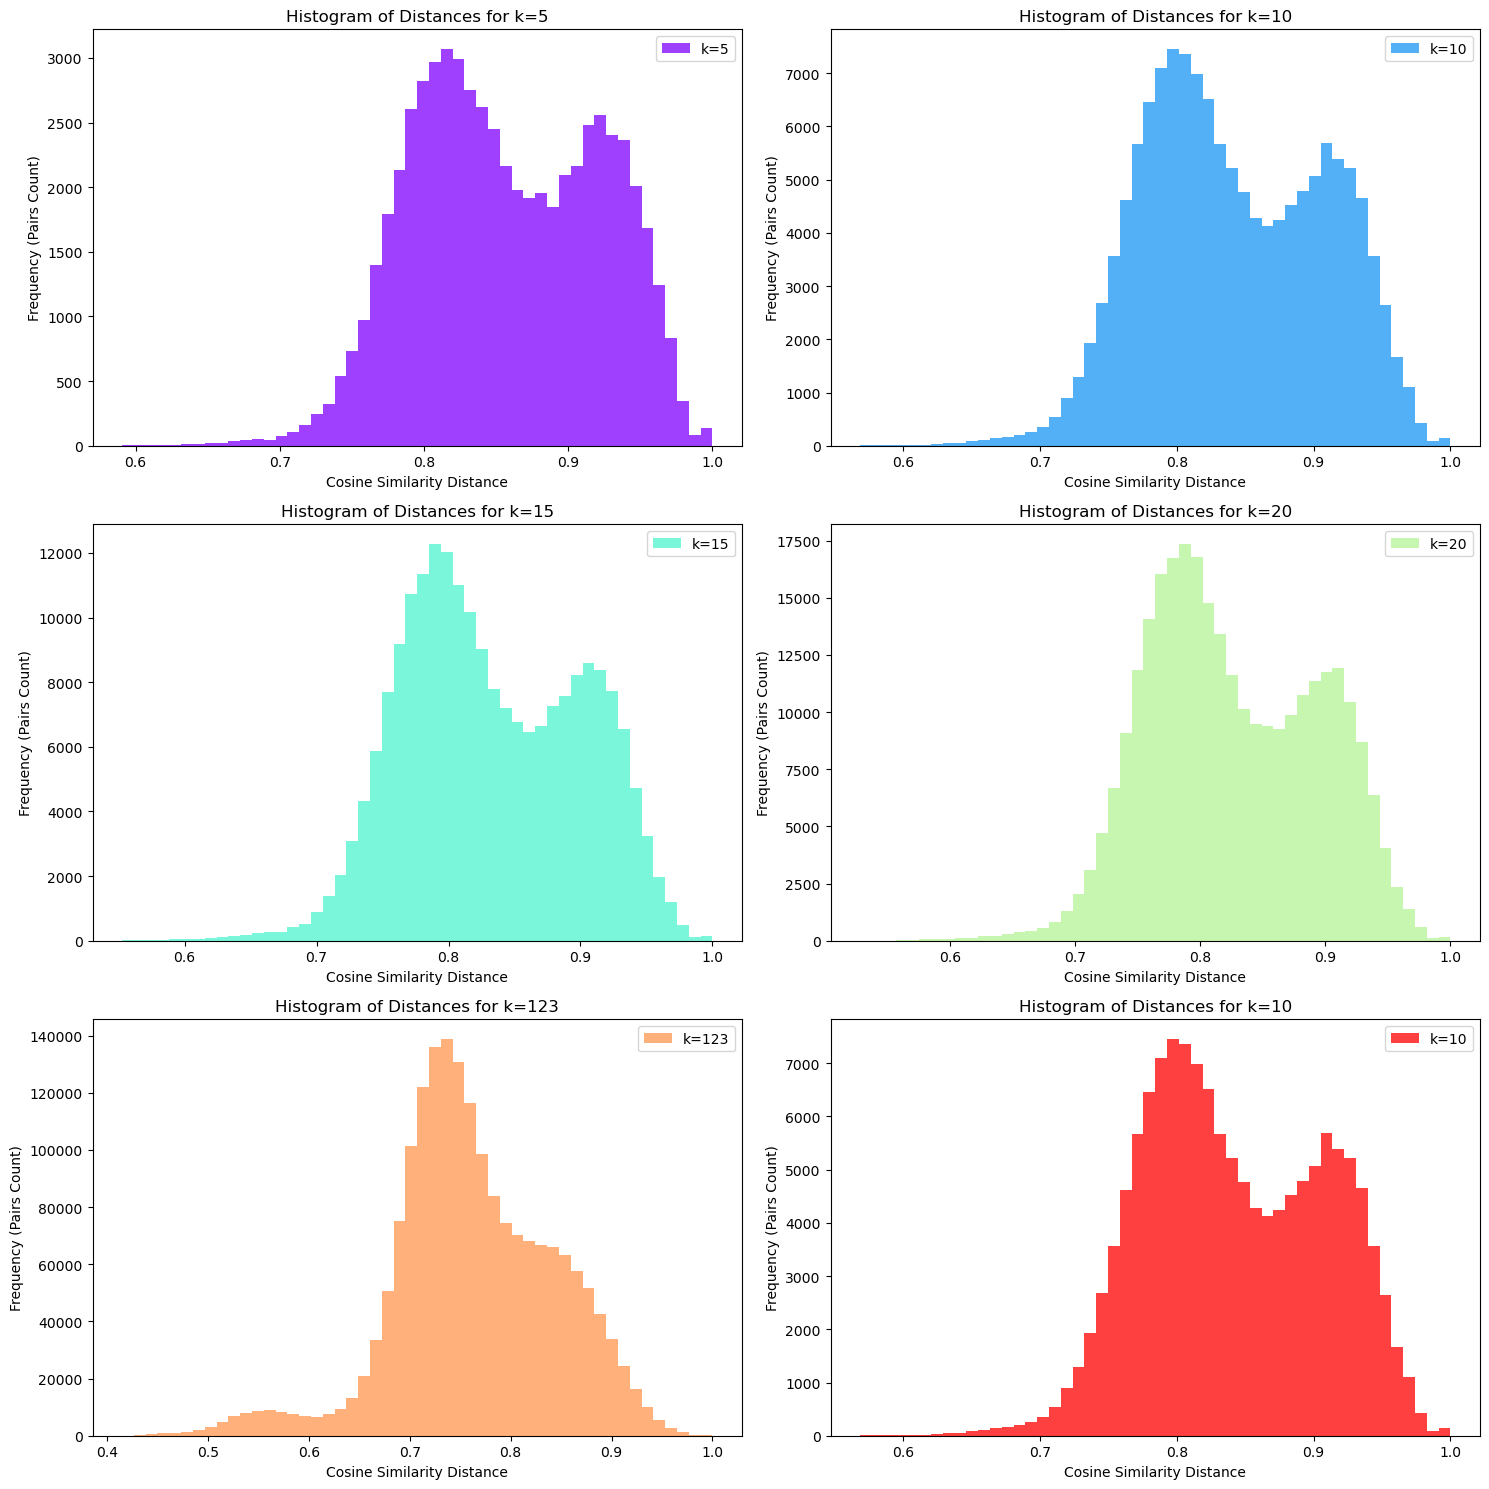

In [19]:
evaluating_thresholds("./embeddings/romi_embeddings/32_H.csv")

Percentiles of Distances for k=5: [0.81268263 0.84281999 0.87972878 0.91946911 0.9375844  0.96263926]
Percentiles of Distances for k=10: [0.79774271 0.82785013 0.86322153 0.90699093 0.92620819 0.95460712]
Percentiles of Distances for k=15: [0.78881149 0.8187798  0.85415065 0.89882243 0.91957053 0.94898781]
Percentiles of Distances for k=20: [0.78226656 0.81231922 0.84756774 0.8927689  0.91447956 0.94494611]
Percentiles of Distances for k=149: [0.72556436 0.75769895 0.79144913 0.83251522 0.86201048 0.90970016]
Percentiles of Distances for k=11: [0.79566891 0.82574689 0.86105436 0.90516847 0.92466062 0.95312329]
Average Percentiles of Distances: [0.78378944 0.8142025  0.8495287  0.89262251 0.91408563 0.94566729]


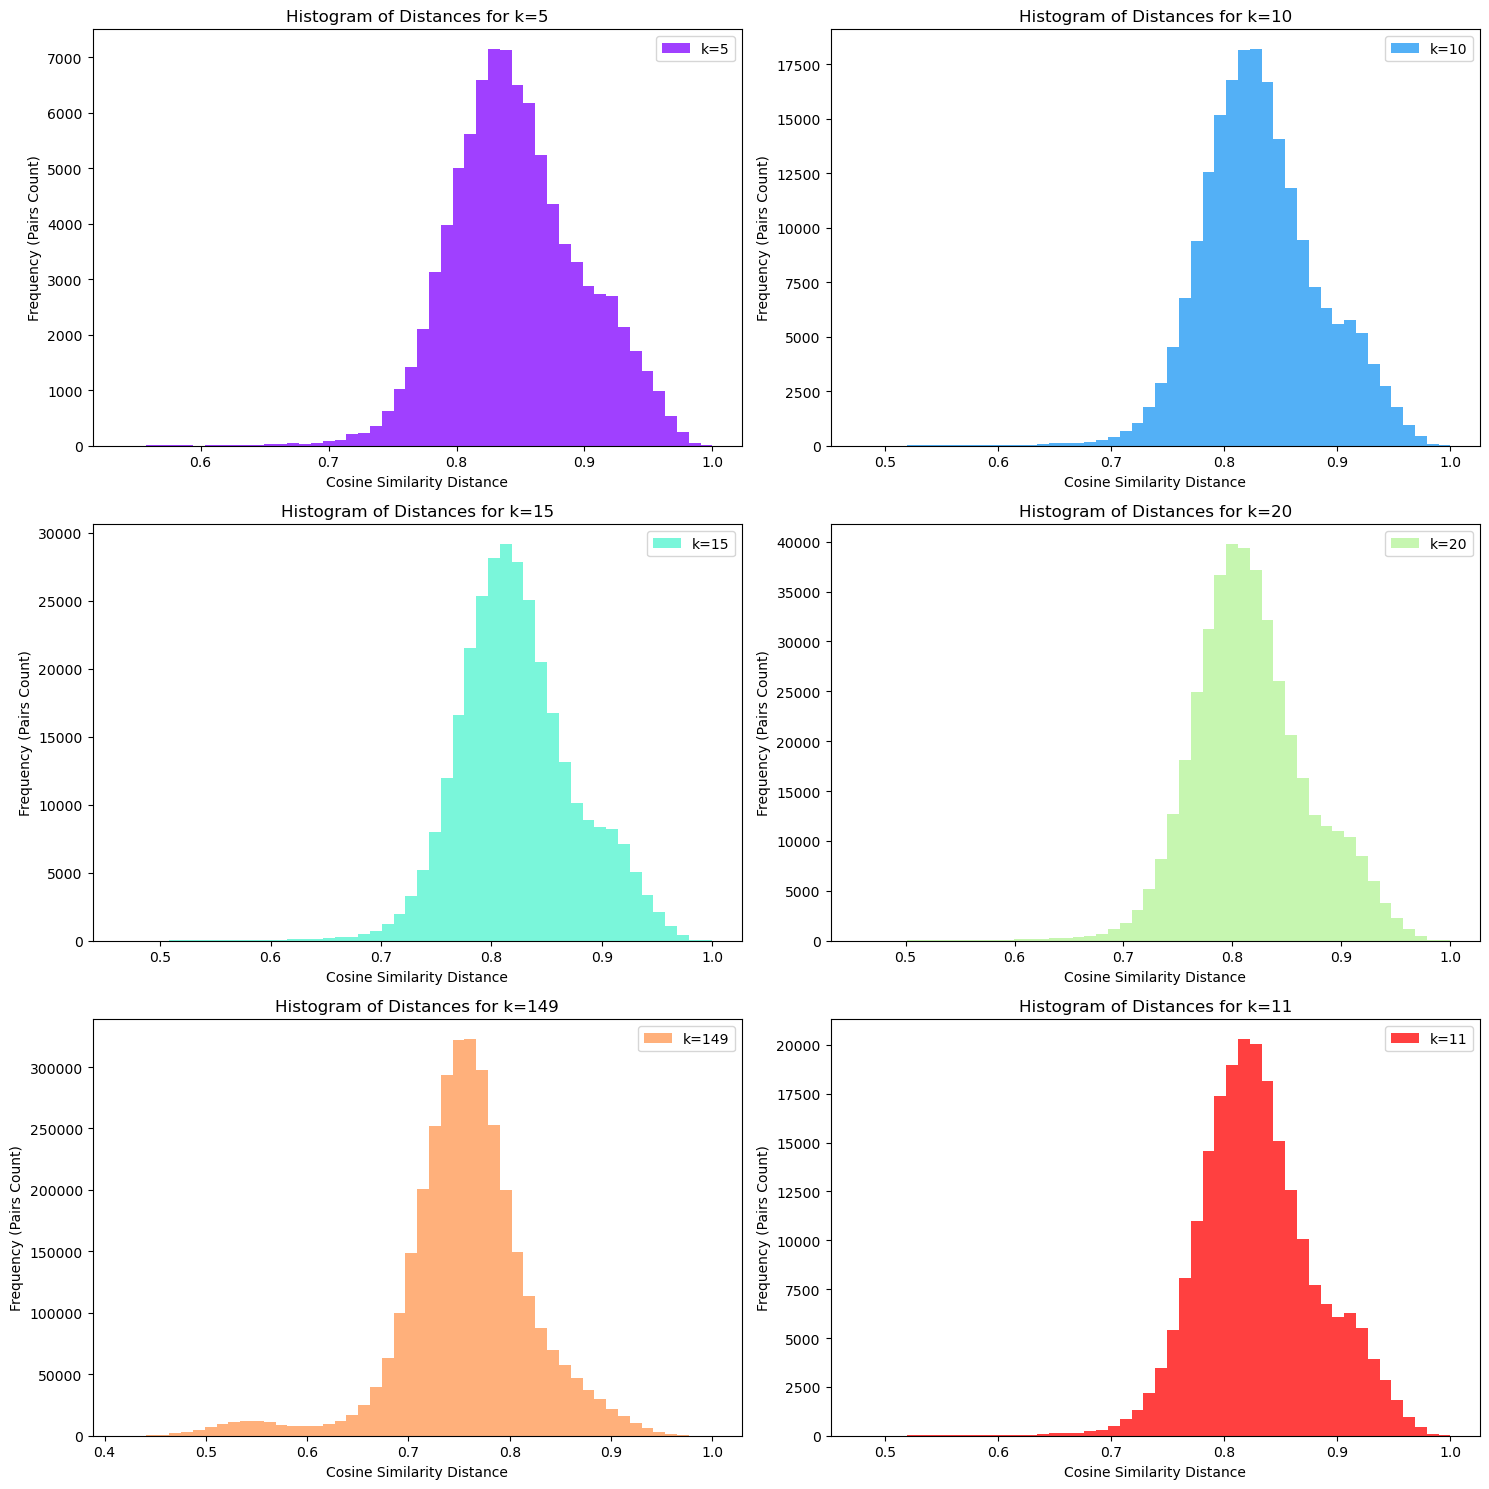

In [17]:
evaluating_thresholds("./embeddings/romi_embeddings/26_OC.csv")

In [10]:
graphs = {}
threshold = 0.9

In [11]:
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_folder, file_name)
        # trimming .csv from file_name
        graphs[file_name.split(".")[0]] = create_graphs_from_embeddings(file_path, threshold)
        

KeyboardInterrupt: 